**PRO задание. Вариант 2**

Используйте на базе обращения граждан в органы власти разбиение текстов на фрагменты, как при распознавании писателей, например, размер блока (xLen) - 20 слов, шаг (step) - 1 слово
Сравните точность с базовым ноутбуком, проверьте 10-20 различных архитектур сети
Напишите функцию распознавания нужного обращения, разделением его на фрагменты и распознаванием фрагментов (так же, как было в ноутбуке про писателей)

#Import библиотек

In [0]:
from google.colab import files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras import utils

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation
from tensorflow.python.keras.optimizers import Adam, RMSprop

from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


##Загрузка файлов

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


##Загрузка данных


In [0]:
df = pd.read_csv('/content/drive/My Drive/UAI/Neuron Networks/Занятие №4 Обработка текстов с помощью нейросетей/clean_data.csv') #загружаем данные в data frame
df = df.iloc[:, :2] #извлечём тексты обращений и соответствующие им категории
print(df.head())    #взглянем на содержимое

                                                text            category
0  Здравствуйте. Подскажите пожалуйста можно ли с...  Дороги и транспорт
1  Подскажите пожалуйста имеют ли право не платит...                 ЖКХ
2  " Спасибо Вам огромное за возобновление строит...       Строительство
3  Проблема одна и общая стала в городе. Спорт. у...               Спорт
4  Некоторое время назад для школьников и студент...  Дороги и транспорт


In [0]:
print(df.shape)

(10059, 2)


In [0]:
print(df.values[0])

Здравствуйте. Подскажите пожалуйста можно ли сделать проезд для школьников по льготной цене. Для людей работающих в бюджетной организации, с детьми на проезд уходит значительная часть денег на оплату проезда .


## Подготовка данных


In [0]:
#################
#Задаем данные
#################
texts = df['text'].values              #извлекаем данные всех текстов из столбца text
classes = list(df['category'].values)  #извлекаем соответствующие им значения классов(лейблов) столбца text
maxWordsCount = 30000                  #зададим макс.кол-во слов/индексов, учитываемое при обучении текстов

print(df['category'].unique())         #выводим все уникальные значения классов
nClasses = df['category'].nunique()+1  #задаём количество классов, обращаясь к столбцу category и оставляя уникальные значения
print(nClasses) #взглянем на количество классов

['Дороги и транспорт' 'ЖКХ' 'Строительство' 'Спорт'
 'Благо\xad\xadустрой\xad\xadство' 'Образование и наука' 'Культура'
 'Демография' 'Социальная сфера' 'Другое' 'Бизнес' 'Здравоохранение'
 'Органы власти' 'Экология' 'Правопорядок' 'Труд и занятость населения'
 'Борьба с коррупцией' 'Промышленность' 'Сельское хозяйство'
 'Земельные отношения' 'Туризм' nan]
22


In [0]:
for i in range(nClasses):
  print(i, classes[i])

0 Дороги и транспорт
1 ЖКХ
2 Строительство
3 Спорт
4 Дороги и транспорт
5 Дороги и транспорт
6 Дороги и транспорт
7 Дороги и транспорт
8 Благо­­устрой­­ство
9 Дороги и транспорт
10 Спорт
11 Дороги и транспорт
12 Спорт
13 Образование и наука
14 Строительство
15 ЖКХ
16 Благо­­устрой­­ство
17 Культура
18 ЖКХ
19 Дороги и транспорт
20 Демография
21 Социальная сфера


In [0]:
# Убираем сообщения в которых меньше 30 символов 
# как не несущие особого смысла
texts_clean = []
class_clean = []
min_con = 50

print('Удалены следующие сообщения')
print('='*70)
for i in range(len(texts)):
  if len(texts[i]) < min_con:
    print(texts[i])
  else:
    texts_clean.append(texts[i])
    class_clean.append(classes[i])
print('='*70)
print('Новый размер базы')
print(len(texts_clean))
print(len(class_clean))

Удалены следующие сообщения
Когда будет достроен бассейн ?
Овощи з п а на заводе и в смены
Вот так кладут асфальт у нас в городе
Вывоз мусора
Колхоз развалился нет работы как выжить
Не вывозят мусор более 2-х дней и больше .
Коллективная жалоба деревни Копцевы Хутора
Предлагаю привлечь в наш город гипермаркеты
Проверка работы
всё описано в жалобе
Очень плохое состояние дороги
Проблема по очистным сооружениям .
Есть Идея развить воздухоплавательный туризм!!!
Не хватает дверец на почтовых ящиках .
проверка работы ЛК администрации г. Липецка
Ответ на сообщение № от 06.12.2018 г .
В городе нет ни современного дворца спорта .
Поздравление!
Не убрано в подъезде .
ПРОСИМ СПАСТИ подругу
не вывозится с 1 января .
В прикрепленном файле
Очень хотелось бы, чтобы это прочитали ХХХХ
Нужна Ваша помощь! Подробности во вложении .
Жалоба на главу Воловского района
Нас затапливает, дом Разваливается .
извините все файлы не влезли, кидаю еще
Дополнительное фото по моей просьбе от 16.01.2019
xxx а это не б

In [0]:
print(texts_clean[0])

Здравствуйте. Подскажите пожалуйста можно ли сделать проезд для школьников по льготной цене. Для людей работающих в бюджетной организации, с детьми на проезд уходит значительная часть денег на оплату проезда .


In [0]:
#################
#Преобразовываем текстовые данные в числовые/векторные для обучения нейросетью
#################

#для этого воспользуемся встроенной в Keras функцией Tokenizer для разбиения текста и превращения в матрицу числовых значений
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ', oov_token='unknown', char_level=False)
#выше задаем параметры:
#(num_words=maxWordsCount) - определяем макс.кол-во слов/индексов, учитываемое при обучении текстов
#(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n') - избавляемся от ненужных символов
#(lower=True) - приводим слова к нижнему регистру
#(split=' ') - разделяем слова по пробелу
#(char_level=False) - просим токенайзер не удалять однобуквенные слова

tokenizer.fit_on_texts(texts_clean)           #"скармливаем" наши тексты, т.е даём в обработку методу, который соберет словарь частотности

In [0]:
print("Размер словаря", len(tokenizer.word_index.items()))

Размер словаря 80581


In [0]:
print("Протестируем словарь частотности")
print("Интересующее слово имеет индекс: ", tokenizer.word_index[input("Уточните слово: ")]) #протестируем словарь частотности

Протестируем словарь частотности
Уточните слово: самолет
Интересующее слово имеет индекс:  10609


In [0]:
#################
#преобразовываем категории в вектора
#################
encoder = LabelEncoder() #вызываем метод кодирования тестовых лейблов из библиотеки sklearn
encoder.fit(class_clean)     #подгружаем в него категории из нашей базы
classesEncoded = encoder.transform(class_clean)           #кодируем категории
yAll = utils.to_categorical(classesEncoded, nClasses) #и выводим каждый лейбл в виде вектора длиной 22, с 1кой в позиции соответсвующего класса и нулями
print(yAll.shape)  #взглянем на форму лейблов категорий
print(yAll[0])     #и отдельно на первую строку

(9943, 22)
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [0]:
print(classesEncoded)
print(len(classesEncoded))

[ 5  7 18 ...  7  7  7]
9943


In [0]:
encoder.inverse_transform([5])

array(['Дороги и транспорт'], dtype='<U26')

In [0]:
for i in range(nClasses):
  print(i, sum(classesEncoded == i))

0 1782
1 179
2 1655
3 59
4 20
5 1392
6 202
7 2051
8 366
9 79
10 99
11 289
12 239
13 170
14 12
15 50
16 368
17 242
18 348
19 150
20 14
21 177


In [0]:
#преобразовываем текст в последовательность индексов согласно частотному словарю
texts_in_WordIndexes = tokenizer.texts_to_sequences(texts_clean) #обучающие тесты в индексы

print("Взглянем на фрагмент обучающего текста:")
print("В виде оригинального текста:              ", texts_clean[5] [:89])
print("Он же в виде последовательности индексов: ", texts_in_WordIndexes[5][:20])
print()

print(len(texts_in_WordIndexes))

Взглянем на фрагмент обучающего текста:
В виде оригинального текста:               Доброго времени суток! Надеюсь, мое сообщение не останется не замеченным, как и проблема,
Он же в виде последовательности индексов:  [968, 221, 648, 326, 418, 855, 5, 2419, 5, 1, 14, 3, 94, 26, 260, 500, 1464, 1008, 1286, 1008]

9943


In [0]:
#Задаём базовые параметры для разбиения обращений на отрезки
xLen = 50 #Длина отрезка текста, по которой анализируем, в словах
step = 25 #Шаг разбиения исходного текста на обучающие вектора

# на меньших размерах xLen и step у Colab не хватет пямяти

In [0]:
# Функция деления вектора сообщения на отрезки (разделение на короткие векторы)
# возвращает список раскусаных сообщений
def split_message(wordIndexes, xLen, step):
  xSample = []
  wordsLen = len(wordIndexes)
  index = 0
  #Идём по всей длине вектора индексов
  
  # Если длинна слов меньше чем длинна отрезка передаем назад все слова
  if wordsLen < xLen:
    xSample = [wordIndexes]
  else:
    #"Откусываем" векторы длины xLen и смещаеммся вперёд на step
    while (index + xLen <= wordsLen):
      xSample.append(wordIndexes[index:index+xLen])
      #print(index, wordIndexes[index:index+xLen])
      index += step
    
  return xSample

In [0]:
# Формируем новую базу из раскусанных кусков сообщений
split_texts_WI = []
split_class_WI = []

for num in range(len(texts_in_WordIndexes)):
  list_cur_class = []
  spl_mes = split_message(texts_in_WordIndexes[num], xLen, step)
  #print(len(spl_mes))
  # добавляем к общему списку раскусанные сообщения
  split_texts_WI.extend(spl_mes)
  # формируем равноразмерный список со значением класса для списка раскусанных сообщений
  for i in range(len(spl_mes)): 
    list_cur_class.append(yAll[num])
  split_class_WI.extend(list_cur_class)

print(len(split_texts_WI))
print(len(split_class_WI))

42881
42881


In [0]:
# преобразуем назад векторы индексов в текстовые сообщения
split_texts = []

items = list(tokenizer.word_index.items())

for num in range(len(split_texts_WI)):
  cur_text = split_texts_WI[num]
  cur_mes = []
  for i in cur_text:
    char = items[i-1][0]
    cur_mes.append(char)
  split_texts.append(cur_mes)
print(len(split_texts))
print(split_texts[0])

42881
['здравствуйте', 'подскажите', 'пожалуйста', 'можно', 'ли', 'сделать', 'проезд', 'для', 'школьников', 'по', 'льготной', 'цене', 'для', 'людей', 'работающих', 'в', 'бюджетной', 'организации', 'с', 'детьми', 'на', 'проезд', 'уходит', 'значительная', 'часть', 'денег', 'на', 'оплату', 'проезда']


In [0]:
# для раскусанных на слова собщениях формируем матрицу индексов по принципу Bag of Words
xAll_clean = tokenizer.texts_to_matrix(split_texts) #каждое слово из текста нашло свой индекс в векторе длиной maxWordsCount отметилось в нем единичкой 
print(xAll_clean.shape)  #взглянем на форму текстов
print(xAll_clean[0, :20])#и отдельно на фрагмент начала вектора

(42881, 30000)
[0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


##Создание обучающей и проверочной выборки


In [0]:
# разбиваем все данные на обучающую и тестовую выборки с помощью метода train_test_split из библиотеки sklearn
print('Общий размер выборки')
print(xAll_clean.shape)
yAll_clean = np.array(split_class_WI)
print(yAll_clean.shape)
xTrain01, xVal01, yTrain, yVal = train_test_split(xAll_clean, yAll_clean, test_size=0.2)
print('Обучающая выборка')
print(xTrain01.shape) #взглянем на форму текстов из обучающей выборки
print(yTrain.shape) #и на форму соответсвующих им классов
print('Валидационная выборка')
print(xVal01.shape) #взглянем на форму текстов из обучающей выборки
print(yVal.shape) #и на форму соответсвующих им классов

Общий размер выборки
(42881, 30000)
(42881, 22)
Обучающая выборка
(34304, 30000)
(34304, 22)
Валидационная выборка
(8577, 30000)
(8577, 22)


## Тестирование архитектур Нейросети

In [0]:
#Функция генерации нейронки
#neoronsL1 - нейронов в первом слое
#neuronsL2 - нейронов в втором слое, 0 - если не делать слой
#neuronsL3 - нейронов в третьем слое, 0 - если не делать слой
#innerActivation - активационная функция скрытых слоёв
#outputActivation - активационная функция выходного слоя
def createNet(neoronsL1, innerActivationL1, neuronsL2, innerActivationL2, neuronsL3, innerActivationL3):
  model = Sequential() #Создаём сеть
  maxWordsCount = xTrain01.shape[1]
  model.add(Dense(neoronsL1, input_dim=maxWordsCount, activation=innerActivationL1)) #Добавляем первый слой
  
  #Если число второго слоя > 0
  #Создаём второй слой
  if (neuronsL2 > 0):
    model.add(Dense(neuronsL2, activation=innerActivationL2))

  #Если число третьего слоя > 0
  #Создаём третий слой
  if (neuronsL3 > 0):
    model.add(Dense(neuronsL3, activation=innerActivationL3))
  
  #Создаём выходной слой
  model.add(Dense(yTrain.shape[1], activation='sigmoid'))
  
  #Компилируем сеть
  model.compile(loss="categorical_crossentropy", optimizer = Adam(lr=0.0001), metrics=["accuracy"])
  
  #Возвращаем созданную сеть
  return model

In [0]:
#Функция обучения и тестирования нейросети сеть
#Net - лист с 6 параметрами сети
#batch_size - размер батча
#epochs - число эпох обучения
#iterations - число запусков сети
def testModel(net, batch_size, epochs, iterations):
  acc = [] #Лист с точностями на проверочной выборке по каждому запуску
  
  #Запускаем iterations раз сеть
  for i in range(iterations):
    #Создаём сеть
    model01 = createNet(net[0], net[1], net[2], net[3], net[4], net[5])
    #Обучаем сеть на выборке, сформированной по bag of words - xTrain01
    history = model01.fit(xTrain01, 
                          yTrain, 
                          epochs = epochs,
                          batch_size = batch_size,
                          validation_data=(xVal01, yVal))

    plt.plot(history.history['acc'], 
            label='Доля верных ответов на обучающем наборе')
    plt.plot(history.history['val_acc'], 
            label='Доля верных ответов на проверочном наборе')
    plt.xlabel('Эпоха обучения')
    plt.ylabel('Доля верных ответов')
    plt.legend()
    plt.show()

    #Добавляем в лист точность на проверочной выборке на последней итерации
    acc.append(history.history["val_acc"][-1])
  
  #Возвращаем лист точностей
  return np.array(acc)

### Тестирование архитектуры сети

In [0]:
# Список для записи результатов тестирования
list_test_net = []
# Создаём сети с различной архитектурой
net = []
net.append([200, 'relu', 0, 'relu', 0, 'relu'])
net.append([300, 'relu', 0, 'relu', 0, 'relu'])
net.append([400, 'relu', 0, 'relu', 0, 'relu'])
net.append([500, 'relu', 0, 'relu', 0, 'relu'])
net.append([600, 'relu', 0, 'relu', 0, 'relu'])

Train on 32471 samples, validate on 8118 samples
Epoch 1/30
32471/32471 [==============================] - 9s 291us/sample - loss: 2.7506 - acc: 0.2237 - val_loss: 2.4003 - val_acc: 0.2406
Epoch 2/30
32471/32471 [==============================] - 9s 283us/sample - loss: 2.1228 - acc: 0.3080 - val_loss: 1.8962 - val_acc: 0.4276
Epoch 3/30
32471/32471 [==============================] - 9s 282us/sample - loss: 1.5204 - acc: 0.5691 - val_loss: 1.4812 - val_acc: 0.5590
Epoch 4/30
32471/32471 [==============================] - 9s 284us/sample - loss: 1.1221 - acc: 0.7143 - val_loss: 1.2800 - val_acc: 0.6305
Epoch 5/30
32471/32471 [==============================] - 9s 284us/sample - loss: 0.8734 - acc: 0.8014 - val_loss: 1.1455 - val_acc: 0.6734
Epoch 6/30
32471/32471 [==============================] - 9s 283us/sample - loss: 0.6938 - acc: 0.8565 - val_loss: 1.0454 - val_acc: 0.7005
Epoch 7/30
32471/32471 [==============================] - 9s 284us/sample - loss: 0.5581 - acc: 0.8949 - val_lo

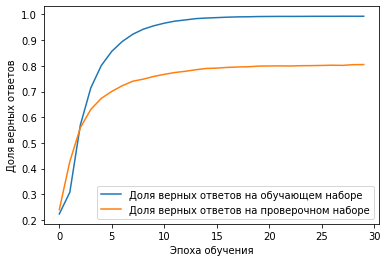

Train on 32471 samples, validate on 8118 samples
Epoch 1/30
32471/32471 [==============================] - 9s 291us/sample - loss: 2.7604 - acc: 0.2356 - val_loss: 2.4284 - val_acc: 0.2641
Epoch 2/30
32471/32471 [==============================] - 9s 284us/sample - loss: 2.1620 - acc: 0.2811 - val_loss: 1.9584 - val_acc: 0.3098
Epoch 3/30
32471/32471 [==============================] - 9s 286us/sample - loss: 1.5555 - acc: 0.5667 - val_loss: 1.4930 - val_acc: 0.5573
Epoch 4/30
32471/32471 [==============================] - 9s 286us/sample - loss: 1.1274 - acc: 0.7182 - val_loss: 1.2822 - val_acc: 0.6318
Epoch 5/30
32471/32471 [==============================] - 9s 282us/sample - loss: 0.8710 - acc: 0.8039 - val_loss: 1.1470 - val_acc: 0.6696
Epoch 6/30
32471/32471 [==============================] - 9s 284us/sample - loss: 0.6888 - acc: 0.8595 - val_loss: 1.0441 - val_acc: 0.7007
Epoch 7/30
32471/32471 [==============================] - 9s 284us/sample - loss: 0.5525 - acc: 0.8961 - val_lo

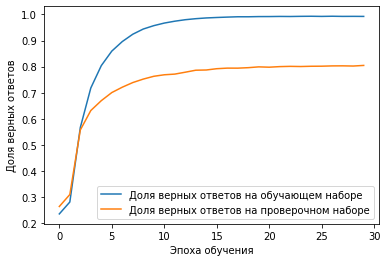

[[200, 'relu', 0, 'relu', 0, 'relu'], 'train_acc = ', 0.8048]

Train on 32471 samples, validate on 8118 samples
Epoch 1/30
32471/32471 [==============================] - 11s 330us/sample - loss: 2.7052 - acc: 0.2659 - val_loss: 2.3448 - val_acc: 0.2600
Epoch 2/30
32471/32471 [==============================] - 11s 324us/sample - loss: 2.0163 - acc: 0.2786 - val_loss: 1.7283 - val_acc: 0.5043
Epoch 3/30
32471/32471 [==============================] - 10s 322us/sample - loss: 1.3290 - acc: 0.6385 - val_loss: 1.3449 - val_acc: 0.6058
Epoch 4/30
32471/32471 [==============================] - 10s 322us/sample - loss: 0.9393 - acc: 0.7784 - val_loss: 1.1594 - val_acc: 0.6640
Epoch 5/30
32471/32471 [==============================] - 10s 323us/sample - loss: 0.7004 - acc: 0.8527 - val_loss: 1.0328 - val_acc: 0.7056
Epoch 6/30
32471/32471 [==============================] - 10s 323us/sample - loss: 0.5341 - acc: 0.8994 - val_loss: 0.9429 - val_acc: 0.7270
Epoch 7/30
32471/32471 [==================

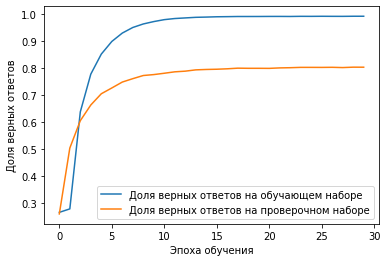

Train on 32471 samples, validate on 8118 samples
Epoch 1/30
32471/32471 [==============================] - 11s 333us/sample - loss: 2.7000 - acc: 0.2679 - val_loss: 2.3072 - val_acc: 0.2642
Epoch 2/30
32471/32471 [==============================] - 10s 323us/sample - loss: 1.9385 - acc: 0.3541 - val_loss: 1.6615 - val_acc: 0.5085
Epoch 3/30
32471/32471 [==============================] - 10s 322us/sample - loss: 1.2816 - acc: 0.6528 - val_loss: 1.3297 - val_acc: 0.6127
Epoch 4/30
32471/32471 [==============================] - 10s 322us/sample - loss: 0.9220 - acc: 0.7824 - val_loss: 1.1517 - val_acc: 0.6694
Epoch 5/30
32471/32471 [==============================] - 10s 322us/sample - loss: 0.6911 - acc: 0.8553 - val_loss: 1.0305 - val_acc: 0.7028
Epoch 6/30
32471/32471 [==============================] - 10s 321us/sample - loss: 0.5281 - acc: 0.9012 - val_loss: 0.9409 - val_acc: 0.7297
Epoch 7/30
32471/32471 [==============================] - 10s 322us/sample - loss: 0.4106 - acc: 0.9318 -

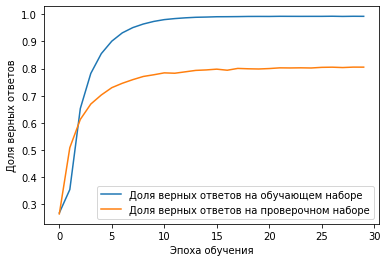

[[300, 'relu', 0, 'relu', 0, 'relu'], 'train_acc = ', 0.8047]

Train on 32471 samples, validate on 8118 samples
Epoch 1/30
32471/32471 [==============================] - 12s 367us/sample - loss: 2.6435 - acc: 0.2609 - val_loss: 2.2534 - val_acc: 0.2180
Epoch 2/30
32471/32471 [==============================] - 12s 358us/sample - loss: 1.8629 - acc: 0.3489 - val_loss: 1.5785 - val_acc: 0.5257
Epoch 3/30
32471/32471 [==============================] - 12s 356us/sample - loss: 1.1822 - acc: 0.6818 - val_loss: 1.2588 - val_acc: 0.6372
Epoch 4/30
32471/32471 [==============================] - 12s 355us/sample - loss: 0.8234 - acc: 0.8108 - val_loss: 1.0869 - val_acc: 0.6907
Epoch 5/30
32471/32471 [==============================] - 12s 356us/sample - loss: 0.5989 - acc: 0.8801 - val_loss: 0.9701 - val_acc: 0.7212
Epoch 6/30
32471/32471 [==============================] - 12s 355us/sample - loss: 0.4461 - acc: 0.9210 - val_loss: 0.8855 - val_acc: 0.7427
Epoch 7/30
32471/32471 [==================

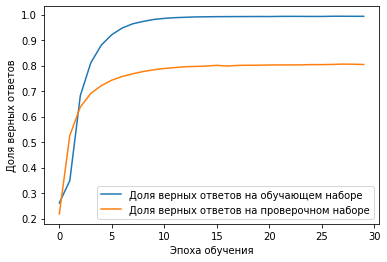

Train on 32471 samples, validate on 8118 samples
Epoch 1/30
32471/32471 [==============================] - 12s 367us/sample - loss: 2.6402 - acc: 0.2726 - val_loss: 2.2458 - val_acc: 0.2496
Epoch 2/30
32471/32471 [==============================] - 12s 355us/sample - loss: 1.8532 - acc: 0.3685 - val_loss: 1.5739 - val_acc: 0.5308
Epoch 3/30
32471/32471 [==============================] - 11s 354us/sample - loss: 1.1789 - acc: 0.6882 - val_loss: 1.2575 - val_acc: 0.6322
Epoch 4/30
32471/32471 [==============================] - 12s 355us/sample - loss: 0.8220 - acc: 0.8108 - val_loss: 1.0837 - val_acc: 0.6887
Epoch 5/30
32471/32471 [==============================] - 12s 355us/sample - loss: 0.5980 - acc: 0.8805 - val_loss: 0.9672 - val_acc: 0.7199
Epoch 6/30
32471/32471 [==============================] - 12s 354us/sample - loss: 0.4449 - acc: 0.9218 - val_loss: 0.8825 - val_acc: 0.7451
Epoch 7/30
32471/32471 [==============================] - 12s 356us/sample - loss: 0.3380 - acc: 0.9472 -

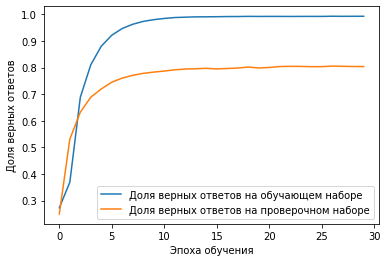

[[400, 'relu', 0, 'relu', 0, 'relu'], 'train_acc = ', 0.804]

Train on 32471 samples, validate on 8118 samples
Epoch 1/30
32471/32471 [==============================] - 13s 392us/sample - loss: 2.6149 - acc: 0.2507 - val_loss: 2.2063 - val_acc: 0.3025
Epoch 2/30
32471/32471 [==============================] - 11s 326us/sample - loss: 1.7522 - acc: 0.4422 - val_loss: 1.4842 - val_acc: 0.5472
Epoch 3/30
32471/32471 [==============================] - 10s 322us/sample - loss: 1.0715 - acc: 0.7219 - val_loss: 1.1901 - val_acc: 0.6576
Epoch 4/30
32471/32471 [==============================] - 10s 321us/sample - loss: 0.7281 - acc: 0.8399 - val_loss: 1.0253 - val_acc: 0.7066
Epoch 5/30
32471/32471 [==============================] - 10s 321us/sample - loss: 0.5163 - acc: 0.9016 - val_loss: 0.9173 - val_acc: 0.7334
Epoch 6/30
32471/32471 [==============================] - 10s 322us/sample - loss: 0.3760 - acc: 0.9380 - val_loss: 0.8398 - val_acc: 0.7541
Epoch 7/30
32471/32471 [===================

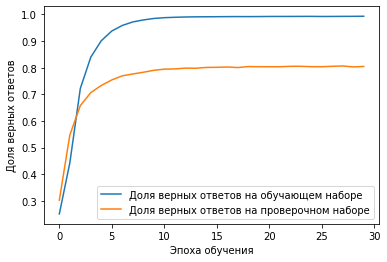

Train on 32471 samples, validate on 8118 samples
Epoch 1/30
32471/32471 [==============================] - 11s 350us/sample - loss: 2.6193 - acc: 0.2789 - val_loss: 2.1909 - val_acc: 0.2328
Epoch 2/30
32471/32471 [==============================] - 11s 338us/sample - loss: 1.7243 - acc: 0.4341 - val_loss: 1.4699 - val_acc: 0.5607
Epoch 3/30
32471/32471 [==============================] - 11s 338us/sample - loss: 1.0601 - acc: 0.7255 - val_loss: 1.1845 - val_acc: 0.6555
Epoch 4/30
32471/32471 [==============================] - 11s 338us/sample - loss: 0.7216 - acc: 0.8407 - val_loss: 1.0209 - val_acc: 0.7072
Epoch 5/30
32471/32471 [==============================] - 11s 339us/sample - loss: 0.5112 - acc: 0.9027 - val_loss: 0.9116 - val_acc: 0.7340
Epoch 6/30
32471/32471 [==============================] - 11s 338us/sample - loss: 0.3722 - acc: 0.9386 - val_loss: 0.8347 - val_acc: 0.7563
Epoch 7/30
32471/32471 [==============================] - 11s 338us/sample - loss: 0.2773 - acc: 0.9599 -

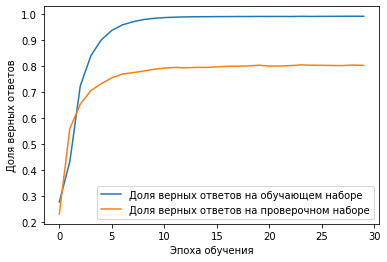

[[500, 'relu', 0, 'relu', 0, 'relu'], 'train_acc = ', 0.8044]

Train on 32471 samples, validate on 8118 samples
Epoch 1/30
32471/32471 [==============================] - 13s 392us/sample - loss: 2.5677 - acc: 0.2678 - val_loss: 2.1475 - val_acc: 0.2231
Epoch 2/30
32471/32471 [==============================] - 12s 378us/sample - loss: 1.6419 - acc: 0.4653 - val_loss: 1.4073 - val_acc: 0.5840
Epoch 3/30
32471/32471 [==============================] - 12s 379us/sample - loss: 0.9817 - acc: 0.7529 - val_loss: 1.1351 - val_acc: 0.6721
Epoch 4/30
32471/32471 [==============================] - 12s 379us/sample - loss: 0.6516 - acc: 0.8619 - val_loss: 0.9769 - val_acc: 0.7142
Epoch 5/30
32471/32471 [==============================] - 12s 378us/sample - loss: 0.4514 - acc: 0.9174 - val_loss: 0.8719 - val_acc: 0.7450
Epoch 6/30
32471/32471 [==============================] - 12s 379us/sample - loss: 0.3229 - acc: 0.9490 - val_loss: 0.8046 - val_acc: 0.7627
Epoch 7/30
32471/32471 [==================

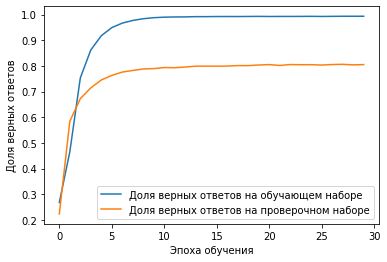

Train on 32471 samples, validate on 8118 samples
Epoch 1/30
32471/32471 [==============================] - 13s 395us/sample - loss: 2.5780 - acc: 0.2704 - val_loss: 2.1539 - val_acc: 0.2121
Epoch 2/30
32471/32471 [==============================] - 12s 381us/sample - loss: 1.6595 - acc: 0.4479 - val_loss: 1.4163 - val_acc: 0.5814
Epoch 3/30
32471/32471 [==============================] - 13s 386us/sample - loss: 0.9879 - acc: 0.7531 - val_loss: 1.1382 - val_acc: 0.6670
Epoch 4/30
32471/32471 [==============================] - 12s 379us/sample - loss: 0.6550 - acc: 0.8614 - val_loss: 0.9813 - val_acc: 0.7178
Epoch 5/30
32471/32471 [==============================] - 12s 379us/sample - loss: 0.4551 - acc: 0.9162 - val_loss: 0.8769 - val_acc: 0.7448
Epoch 6/30
32471/32471 [==============================] - 12s 378us/sample - loss: 0.3262 - acc: 0.9482 - val_loss: 0.8068 - val_acc: 0.7634
Epoch 7/30
32471/32471 [==============================] - 12s 379us/sample - loss: 0.2406 - acc: 0.9655 -

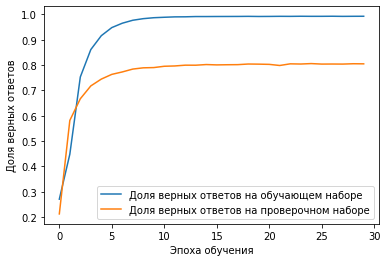

[[600, 'relu', 0, 'relu', 0, 'relu'], 'train_acc = ', 0.8049]

Результаты тестирования архитектуры сети
[[200, 'relu', 0, 'relu', 0, 'relu'], 'train_acc = ', 0.8048]
[[300, 'relu', 0, 'relu', 0, 'relu'], 'train_acc = ', 0.8047]
[[400, 'relu', 0, 'relu', 0, 'relu'], 'train_acc = ', 0.804]
[[500, 'relu', 0, 'relu', 0, 'relu'], 'train_acc = ', 0.8044]
[[600, 'relu', 0, 'relu', 0, 'relu'], 'train_acc = ', 0.8049]


In [0]:
list_test_net = []
#Обучаем каждую сеть и выводим среднюю точность на проверочной выборке по 3 запускам
for currNet in net:
  acc = testModel(net = currNet, batch_size = 128, epochs = 30, iterations = 2)
  list_test_net.append([currNet, 'train_acc = ', round(sum(acc)/len(acc),4)])
  print(list_test_net[-1])
  print('='*100)
  print()

print('Результаты тестирования архитектуры сети')
for i in list_test_net:
  print(i)

##  Исследуем влияние активационной функции для Dense слоя

In [0]:
# Список для записи результатов тестирования
list_test_net = []
# Создаём сети с различной архитектурой
net = []
net.append([400, 'relu', 0, 'relu', 0, 'relu'])
net.append([400, 'elu', 0, 'relu', 0, 'relu'])
net.append([400, 'selu', 0, 'relu', 0, 'relu'])
net.append([400, 'softplus', 0, 'relu', 0, 'relu'])
net.append([400, 'softsign', 0, 'relu', 0, 'relu'])
net.append([400, 'tanh', 0, 'relu', 0, 'relu'])
net.append([400, 'sigmoid', 0, 'relu', 0, 'relu'])
net.append([400, 'hard_sigmoid', 0, 'relu', 0, 'relu'])
net.append([400, 'exponential', 0, 'relu', 0, 'relu'])
net.append([400, 'linear', 0, 'relu', 0, 'relu'])

Train on 32471 samples, validate on 8118 samples
Epoch 1/30
32471/32471 [==============================] - 13s 390us/sample - loss: 2.6536 - acc: 0.2776 - val_loss: 2.2609 - val_acc: 0.2730
Epoch 2/30
32471/32471 [==============================] - 13s 387us/sample - loss: 1.8659 - acc: 0.3540 - val_loss: 1.5849 - val_acc: 0.5333
Epoch 3/30
32471/32471 [==============================] - 13s 387us/sample - loss: 1.1759 - acc: 0.6910 - val_loss: 1.2593 - val_acc: 0.6398
Epoch 4/30
32471/32471 [==============================] - 12s 384us/sample - loss: 0.8148 - acc: 0.8184 - val_loss: 1.0850 - val_acc: 0.6823
Epoch 5/30
32471/32471 [==============================] - 13s 389us/sample - loss: 0.5919 - acc: 0.8820 - val_loss: 0.9641 - val_acc: 0.7177
Epoch 6/30
32471/32471 [==============================] - 12s 384us/sample - loss: 0.4409 - acc: 0.9222 - val_loss: 0.8808 - val_acc: 0.7347
Epoch 7/30
32471/32471 [==============================] - 12s 381us/sample - loss: 0.3351 - acc: 0.9472 -

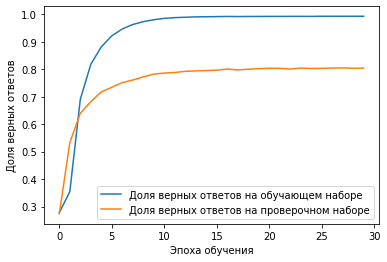

Train on 32471 samples, validate on 8118 samples
Epoch 1/30
32471/32471 [==============================] - 13s 395us/sample - loss: 2.6390 - acc: 0.2715 - val_loss: 2.2544 - val_acc: 0.2693
Epoch 2/30
32471/32471 [==============================] - 13s 393us/sample - loss: 1.8416 - acc: 0.3940 - val_loss: 1.5736 - val_acc: 0.5520
Epoch 3/30
32471/32471 [==============================] - 13s 392us/sample - loss: 1.1668 - acc: 0.6978 - val_loss: 1.2603 - val_acc: 0.6391
Epoch 4/30
32471/32471 [==============================] - 13s 388us/sample - loss: 0.8132 - acc: 0.8186 - val_loss: 1.0876 - val_acc: 0.6810
Epoch 5/30
32471/32471 [==============================] - 12s 376us/sample - loss: 0.5914 - acc: 0.8832 - val_loss: 0.9688 - val_acc: 0.7125
Epoch 6/30
32471/32471 [==============================] - 12s 372us/sample - loss: 0.4401 - acc: 0.9227 - val_loss: 0.8840 - val_acc: 0.7339
Epoch 7/30
32471/32471 [==============================] - 12s 385us/sample - loss: 0.3341 - acc: 0.9473 -

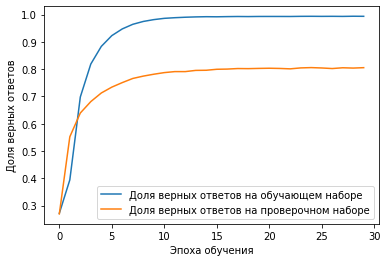

Train on 32471 samples, validate on 8118 samples
Epoch 1/30
32471/32471 [==============================] - 13s 398us/sample - loss: 2.6458 - acc: 0.2604 - val_loss: 2.2565 - val_acc: 0.3044
Epoch 2/30
32471/32471 [==============================] - 13s 389us/sample - loss: 1.8519 - acc: 0.4137 - val_loss: 1.5730 - val_acc: 0.5390
Epoch 3/30
32471/32471 [==============================] - 13s 391us/sample - loss: 1.1709 - acc: 0.6964 - val_loss: 1.2586 - val_acc: 0.6371
Epoch 4/30
32471/32471 [==============================] - 13s 393us/sample - loss: 0.8162 - acc: 0.8162 - val_loss: 1.0854 - val_acc: 0.6838
Epoch 5/30
32471/32471 [==============================] - 13s 394us/sample - loss: 0.5938 - acc: 0.8821 - val_loss: 0.9675 - val_acc: 0.7135
Epoch 6/30
32471/32471 [==============================] - 13s 394us/sample - loss: 0.4425 - acc: 0.9208 - val_loss: 0.8825 - val_acc: 0.7381
Epoch 7/30
32471/32471 [==============================] - 13s 393us/sample - loss: 0.3364 - acc: 0.9462 -

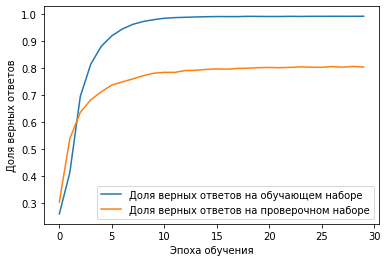

[[400, 'relu', 0, 'relu', 0, 'relu'], 'train_acc = ', 0.8048]

Train on 32471 samples, validate on 8118 samples
Epoch 1/30
32471/32471 [==============================] - 13s 405us/sample - loss: 2.5527 - acc: 0.2656 - val_loss: 2.1887 - val_acc: 0.2455
Epoch 2/30
32471/32471 [==============================] - 13s 387us/sample - loss: 1.8463 - acc: 0.3497 - val_loss: 1.6272 - val_acc: 0.5134
Epoch 3/30
32471/32471 [==============================] - 13s 390us/sample - loss: 1.2233 - acc: 0.6712 - val_loss: 1.2895 - val_acc: 0.6263
Epoch 4/30
32471/32471 [==============================] - 13s 388us/sample - loss: 0.8480 - acc: 0.8087 - val_loss: 1.0979 - val_acc: 0.6816
Epoch 5/30
32471/32471 [==============================] - 13s 391us/sample - loss: 0.6062 - acc: 0.8785 - val_loss: 0.9691 - val_acc: 0.7095
Epoch 6/30
32471/32471 [==============================] - 12s 384us/sample - loss: 0.4421 - acc: 0.9207 - val_loss: 0.8762 - val_acc: 0.7343
Epoch 7/30
32471/32471 [==================

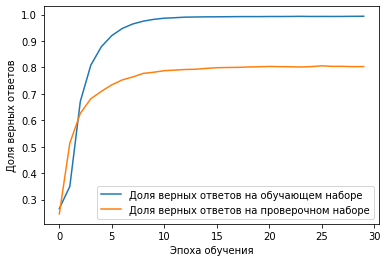

Train on 32471 samples, validate on 8118 samples
Epoch 1/30
32471/32471 [==============================] - 13s 397us/sample - loss: 2.5619 - acc: 0.2644 - val_loss: 2.1922 - val_acc: 0.2360
Epoch 2/30
32471/32471 [==============================] - 13s 388us/sample - loss: 1.8376 - acc: 0.3510 - val_loss: 1.6165 - val_acc: 0.5209
Epoch 3/30
32471/32471 [==============================] - 13s 390us/sample - loss: 1.2156 - acc: 0.6767 - val_loss: 1.2890 - val_acc: 0.6333
Epoch 4/30
32471/32471 [==============================] - 13s 387us/sample - loss: 0.8477 - acc: 0.8092 - val_loss: 1.1000 - val_acc: 0.6765
Epoch 5/30
32471/32471 [==============================] - 13s 390us/sample - loss: 0.6081 - acc: 0.8786 - val_loss: 0.9693 - val_acc: 0.7158
Epoch 6/30
32471/32471 [==============================] - 13s 389us/sample - loss: 0.4447 - acc: 0.9201 - val_loss: 0.8780 - val_acc: 0.7386
Epoch 7/30
32471/32471 [==============================] - 13s 389us/sample - loss: 0.3309 - acc: 0.9472 -

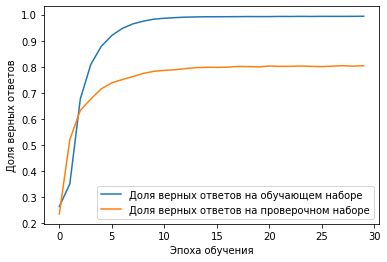

Train on 32471 samples, validate on 8118 samples
Epoch 1/30
32471/32471 [==============================] - 13s 393us/sample - loss: 2.5516 - acc: 0.2693 - val_loss: 2.1925 - val_acc: 0.2275
Epoch 2/30
32471/32471 [==============================] - 13s 392us/sample - loss: 1.8674 - acc: 0.3156 - val_loss: 1.6459 - val_acc: 0.5099
Epoch 3/30
32471/32471 [==============================] - 13s 386us/sample - loss: 1.2356 - acc: 0.6649 - val_loss: 1.2907 - val_acc: 0.6255
Epoch 4/30
32471/32471 [==============================] - 13s 389us/sample - loss: 0.8507 - acc: 0.8029 - val_loss: 1.0974 - val_acc: 0.6810
Epoch 5/30
32471/32471 [==============================] - 13s 386us/sample - loss: 0.6054 - acc: 0.8770 - val_loss: 0.9672 - val_acc: 0.7121
Epoch 6/30
32471/32471 [==============================] - 13s 391us/sample - loss: 0.4396 - acc: 0.9199 - val_loss: 0.8744 - val_acc: 0.7348
Epoch 7/30
32471/32471 [==============================] - 12s 382us/sample - loss: 0.3254 - acc: 0.9476 -

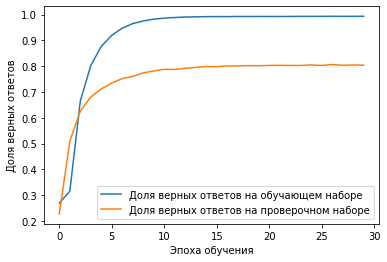

[[400, 'elu', 0, 'relu', 0, 'relu'], 'train_acc = ', 0.8039]

Train on 32471 samples, validate on 8118 samples
Epoch 1/30
32471/32471 [==============================] - 13s 399us/sample - loss: 2.4642 - acc: 0.2516 - val_loss: 2.0673 - val_acc: 0.2052
Epoch 2/30
32471/32471 [==============================] - 13s 391us/sample - loss: 1.5988 - acc: 0.4724 - val_loss: 1.4180 - val_acc: 0.5830
Epoch 3/30
32471/32471 [==============================] - 13s 391us/sample - loss: 0.9843 - acc: 0.7591 - val_loss: 1.1388 - val_acc: 0.6710
Epoch 4/30
32471/32471 [==============================] - 13s 391us/sample - loss: 0.6569 - acc: 0.8629 - val_loss: 0.9772 - val_acc: 0.7120
Epoch 5/30
32471/32471 [==============================] - 13s 392us/sample - loss: 0.4540 - acc: 0.9177 - val_loss: 0.8679 - val_acc: 0.7417
Epoch 6/30
32471/32471 [==============================] - 13s 389us/sample - loss: 0.3224 - acc: 0.9492 - val_loss: 0.7933 - val_acc: 0.7593
Epoch 7/30
32471/32471 [===================

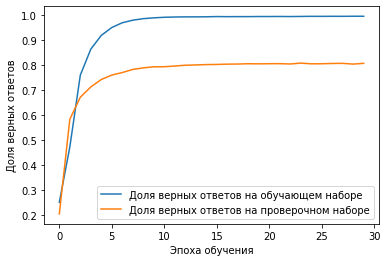

Train on 32471 samples, validate on 8118 samples
Epoch 1/30
32471/32471 [==============================] - 13s 412us/sample - loss: 2.4870 - acc: 0.2593 - val_loss: 2.0890 - val_acc: 0.2779
Epoch 2/30
32471/32471 [==============================] - 13s 398us/sample - loss: 1.6144 - acc: 0.4802 - val_loss: 1.4194 - val_acc: 0.5904
Epoch 3/30
32471/32471 [==============================] - 13s 400us/sample - loss: 0.9827 - acc: 0.7590 - val_loss: 1.1363 - val_acc: 0.6746
Epoch 4/30
32471/32471 [==============================] - 13s 397us/sample - loss: 0.6501 - acc: 0.8664 - val_loss: 0.9702 - val_acc: 0.7166
Epoch 5/30
32471/32471 [==============================] - 13s 398us/sample - loss: 0.4476 - acc: 0.9205 - val_loss: 0.8653 - val_acc: 0.7408
Epoch 6/30
32471/32471 [==============================] - 13s 399us/sample - loss: 0.3174 - acc: 0.9511 - val_loss: 0.7901 - val_acc: 0.7611
Epoch 7/30
32471/32471 [==============================] - 13s 399us/sample - loss: 0.2311 - acc: 0.9697 -

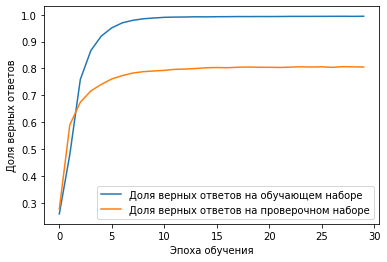

Train on 32471 samples, validate on 8118 samples
Epoch 1/30
32471/32471 [==============================] - 13s 413us/sample - loss: 2.4690 - acc: 0.2436 - val_loss: 2.0692 - val_acc: 0.2015
Epoch 2/30
32471/32471 [==============================] - 13s 398us/sample - loss: 1.6208 - acc: 0.4331 - val_loss: 1.4273 - val_acc: 0.5785
Epoch 3/30
32471/32471 [==============================] - 13s 397us/sample - loss: 0.9948 - acc: 0.7552 - val_loss: 1.1444 - val_acc: 0.6622
Epoch 4/30
32471/32471 [==============================] - 13s 400us/sample - loss: 0.6605 - acc: 0.8630 - val_loss: 0.9782 - val_acc: 0.7118
Epoch 5/30
32471/32471 [==============================] - 13s 400us/sample - loss: 0.4554 - acc: 0.9180 - val_loss: 0.8697 - val_acc: 0.7364
Epoch 6/30
32471/32471 [==============================] - 13s 391us/sample - loss: 0.3228 - acc: 0.9494 - val_loss: 0.7961 - val_acc: 0.7571
Epoch 7/30
32471/32471 [==============================] - 13s 397us/sample - loss: 0.2351 - acc: 0.9685 -

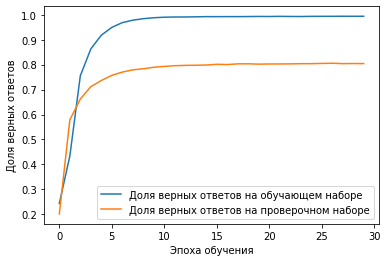

[[400, 'selu', 0, 'relu', 0, 'relu'], 'train_acc = ', 0.8052]

Train on 32471 samples, validate on 8118 samples
Epoch 1/30
32471/32471 [==============================] - 13s 414us/sample - loss: 2.6167 - acc: 0.2136 - val_loss: 2.3147 - val_acc: 0.3027
Epoch 2/30
32471/32471 [==============================] - 13s 396us/sample - loss: 2.0879 - acc: 0.3877 - val_loss: 1.9504 - val_acc: 0.4473
Epoch 3/30
32471/32471 [==============================] - 13s 397us/sample - loss: 1.6678 - acc: 0.5268 - val_loss: 1.6692 - val_acc: 0.5186
Epoch 4/30
32471/32471 [==============================] - 13s 390us/sample - loss: 1.3593 - acc: 0.6275 - val_loss: 1.4792 - val_acc: 0.5645
Epoch 5/30
32471/32471 [==============================] - 13s 394us/sample - loss: 1.1241 - acc: 0.7148 - val_loss: 1.3343 - val_acc: 0.6121
Epoch 6/30
32471/32471 [==============================] - 13s 395us/sample - loss: 0.9340 - acc: 0.7801 - val_loss: 1.2178 - val_acc: 0.6439
Epoch 7/30
32471/32471 [==================

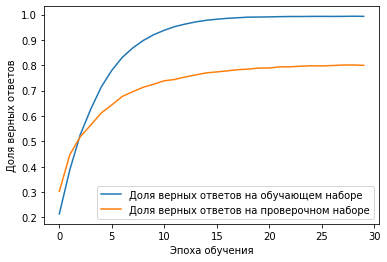

Train on 32471 samples, validate on 8118 samples
Epoch 1/30
32471/32471 [==============================] - 13s 412us/sample - loss: 2.5182 - acc: 0.1932 - val_loss: 2.3239 - val_acc: 0.1997
Epoch 2/30
32471/32471 [==============================] - 13s 388us/sample - loss: 2.0920 - acc: 0.3346 - val_loss: 1.9185 - val_acc: 0.4473
Epoch 3/30
32471/32471 [==============================] - 13s 395us/sample - loss: 1.6207 - acc: 0.5407 - val_loss: 1.6230 - val_acc: 0.5239
Epoch 4/30
32471/32471 [==============================] - 13s 394us/sample - loss: 1.3050 - acc: 0.6449 - val_loss: 1.4385 - val_acc: 0.5694
Epoch 5/30
32471/32471 [==============================] - 13s 394us/sample - loss: 1.0737 - acc: 0.7307 - val_loss: 1.2982 - val_acc: 0.6123
Epoch 6/30
32471/32471 [==============================] - 13s 398us/sample - loss: 0.8879 - acc: 0.7967 - val_loss: 1.1868 - val_acc: 0.6577
Epoch 7/30
32471/32471 [==============================] - 13s 393us/sample - loss: 0.7367 - acc: 0.8428 -

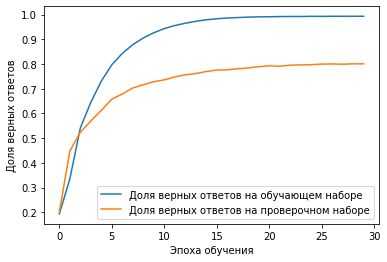

Train on 32471 samples, validate on 8118 samples
Epoch 1/30
32471/32471 [==============================] - 13s 410us/sample - loss: 2.5277 - acc: 0.1799 - val_loss: 2.3235 - val_acc: 0.1997
Epoch 2/30
32471/32471 [==============================] - 13s 395us/sample - loss: 2.1043 - acc: 0.3028 - val_loss: 1.9266 - val_acc: 0.4341
Epoch 3/30
32471/32471 [==============================] - 13s 394us/sample - loss: 1.6208 - acc: 0.5346 - val_loss: 1.6203 - val_acc: 0.5198
Epoch 4/30
32471/32471 [==============================] - 13s 395us/sample - loss: 1.2996 - acc: 0.6503 - val_loss: 1.4325 - val_acc: 0.5855
Epoch 5/30
32471/32471 [==============================] - 13s 394us/sample - loss: 1.0663 - acc: 0.7384 - val_loss: 1.2937 - val_acc: 0.6128
Epoch 6/30
32471/32471 [==============================] - 13s 394us/sample - loss: 0.8813 - acc: 0.8008 - val_loss: 1.1814 - val_acc: 0.6606
Epoch 7/30
32471/32471 [==============================] - 13s 397us/sample - loss: 0.7299 - acc: 0.8457 -

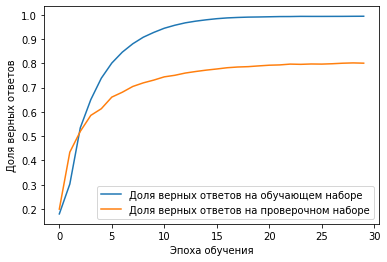

[[400, 'softplus', 0, 'relu', 0, 'relu'], 'train_acc = ', 0.8003]

Train on 32471 samples, validate on 8118 samples
Epoch 1/30
32471/32471 [==============================] - 14s 424us/sample - loss: 2.6078 - acc: 0.2401 - val_loss: 2.2960 - val_acc: 0.2759
Epoch 2/30
32471/32471 [==============================] - 13s 410us/sample - loss: 2.0543 - acc: 0.2770 - val_loss: 1.9049 - val_acc: 0.3921
Epoch 3/30
32471/32471 [==============================] - 13s 396us/sample - loss: 1.5406 - acc: 0.5724 - val_loss: 1.5002 - val_acc: 0.5659
Epoch 4/30
32471/32471 [==============================] - 13s 392us/sample - loss: 1.1259 - acc: 0.7280 - val_loss: 1.2647 - val_acc: 0.6378
Epoch 5/30
32471/32471 [==============================] - 13s 402us/sample - loss: 0.8393 - acc: 0.8213 - val_loss: 1.1021 - val_acc: 0.6854
Epoch 6/30
32471/32471 [==============================] - 13s 402us/sample - loss: 0.6303 - acc: 0.8792 - val_loss: 0.9842 - val_acc: 0.7164
Epoch 7/30
32471/32471 [==============

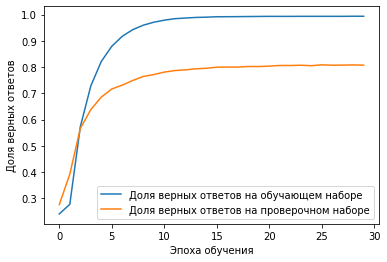

Train on 32471 samples, validate on 8118 samples
Epoch 1/30
32471/32471 [==============================] - 14s 428us/sample - loss: 2.6053 - acc: 0.2723 - val_loss: 2.2869 - val_acc: 0.3049
Epoch 2/30
32471/32471 [==============================] - 13s 409us/sample - loss: 2.0404 - acc: 0.2825 - val_loss: 1.8823 - val_acc: 0.4056
Epoch 3/30
32471/32471 [==============================] - 13s 411us/sample - loss: 1.5240 - acc: 0.5760 - val_loss: 1.4943 - val_acc: 0.5612
Epoch 4/30
32471/32471 [==============================] - 13s 407us/sample - loss: 1.1218 - acc: 0.7256 - val_loss: 1.2666 - val_acc: 0.6308
Epoch 5/30
32471/32471 [==============================] - 13s 408us/sample - loss: 0.8401 - acc: 0.8216 - val_loss: 1.1057 - val_acc: 0.6796
Epoch 6/30
32471/32471 [==============================] - 13s 409us/sample - loss: 0.6332 - acc: 0.8780 - val_loss: 0.9878 - val_acc: 0.7113
Epoch 7/30
32471/32471 [==============================] - 13s 410us/sample - loss: 0.4811 - acc: 0.9170 -

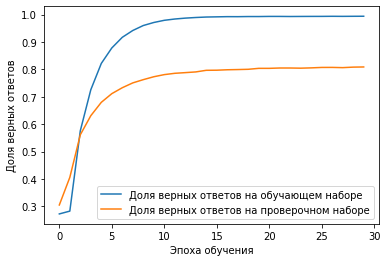

Train on 32471 samples, validate on 8118 samples
Epoch 1/30
32471/32471 [==============================] - 14s 426us/sample - loss: 2.6065 - acc: 0.2730 - val_loss: 2.2915 - val_acc: 0.2566
Epoch 2/30
32471/32471 [==============================] - 13s 410us/sample - loss: 2.0467 - acc: 0.2448 - val_loss: 1.8901 - val_acc: 0.4112
Epoch 3/30
32471/32471 [==============================] - 13s 409us/sample - loss: 1.5314 - acc: 0.5782 - val_loss: 1.4971 - val_acc: 0.5580
Epoch 4/30
32471/32471 [==============================] - 13s 408us/sample - loss: 1.1238 - acc: 0.7252 - val_loss: 1.2661 - val_acc: 0.6354
Epoch 5/30
32471/32471 [==============================] - 13s 410us/sample - loss: 0.8383 - acc: 0.8212 - val_loss: 1.1028 - val_acc: 0.6849
Epoch 6/30
32471/32471 [==============================] - 13s 408us/sample - loss: 0.6298 - acc: 0.8792 - val_loss: 0.9848 - val_acc: 0.7118
Epoch 7/30
32471/32471 [==============================] - 13s 409us/sample - loss: 0.4771 - acc: 0.9176 -

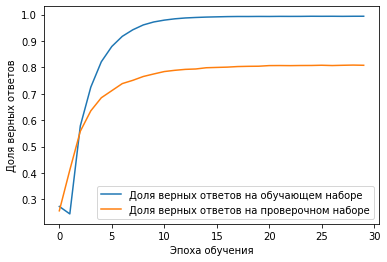

[[400, 'softsign', 0, 'relu', 0, 'relu'], 'train_acc = ', 0.808]

Train on 32471 samples, validate on 8118 samples
Epoch 1/30
32471/32471 [==============================] - 14s 429us/sample - loss: 2.5491 - acc: 0.2481 - val_loss: 2.1838 - val_acc: 0.2078
Epoch 2/30
32471/32471 [==============================] - 13s 411us/sample - loss: 1.8785 - acc: 0.2901 - val_loss: 1.6728 - val_acc: 0.5051
Epoch 3/30
32471/32471 [==============================] - 13s 407us/sample - loss: 1.2749 - acc: 0.6539 - val_loss: 1.3206 - val_acc: 0.6173
Epoch 4/30
32471/32471 [==============================] - 13s 409us/sample - loss: 0.9011 - acc: 0.7911 - val_loss: 1.1297 - val_acc: 0.6752
Epoch 5/30
32471/32471 [==============================] - 13s 409us/sample - loss: 0.6606 - acc: 0.8654 - val_loss: 0.9999 - val_acc: 0.7020
Epoch 6/30
32471/32471 [==============================] - 13s 409us/sample - loss: 0.4932 - acc: 0.9097 - val_loss: 0.9054 - val_acc: 0.7299
Epoch 7/30
32471/32471 [===============

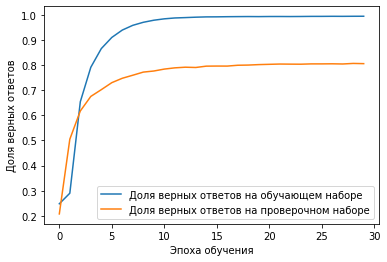

Train on 32471 samples, validate on 8118 samples
Epoch 1/30
32471/32471 [==============================] - 14s 430us/sample - loss: 2.5513 - acc: 0.2419 - val_loss: 2.1883 - val_acc: 0.2010
Epoch 2/30
32471/32471 [==============================] - 13s 410us/sample - loss: 1.8454 - acc: 0.3296 - val_loss: 1.6281 - val_acc: 0.5289
Epoch 3/30
32471/32471 [==============================] - 13s 408us/sample - loss: 1.2428 - acc: 0.6677 - val_loss: 1.3139 - val_acc: 0.6206
Epoch 4/30
32471/32471 [==============================] - 13s 408us/sample - loss: 0.8917 - acc: 0.7957 - val_loss: 1.1285 - val_acc: 0.6738
Epoch 5/30
32471/32471 [==============================] - 13s 406us/sample - loss: 0.6588 - acc: 0.8664 - val_loss: 1.0037 - val_acc: 0.7030
Epoch 6/30
32471/32471 [==============================] - 13s 409us/sample - loss: 0.4947 - acc: 0.9095 - val_loss: 0.9082 - val_acc: 0.7324
Epoch 7/30
32471/32471 [==============================] - 13s 409us/sample - loss: 0.3767 - acc: 0.9384 -

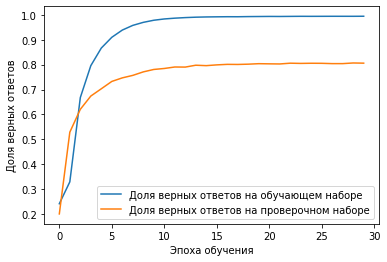

Train on 32471 samples, validate on 8118 samples
Epoch 1/30
32471/32471 [==============================] - 14s 437us/sample - loss: 2.5543 - acc: 0.2649 - val_loss: 2.1866 - val_acc: 0.2275
Epoch 2/30
32471/32471 [==============================] - 13s 414us/sample - loss: 1.8574 - acc: 0.3256 - val_loss: 1.6428 - val_acc: 0.5282
Epoch 3/30
32471/32471 [==============================] - 13s 415us/sample - loss: 1.2527 - acc: 0.6700 - val_loss: 1.3145 - val_acc: 0.6160
Epoch 4/30
32471/32471 [==============================] - 13s 415us/sample - loss: 0.8948 - acc: 0.7943 - val_loss: 1.1292 - val_acc: 0.6731
Epoch 5/30
32471/32471 [==============================] - 13s 415us/sample - loss: 0.6596 - acc: 0.8649 - val_loss: 1.0007 - val_acc: 0.7068
Epoch 6/30
32471/32471 [==============================] - 13s 413us/sample - loss: 0.4945 - acc: 0.9095 - val_loss: 0.9065 - val_acc: 0.7291
Epoch 7/30
32471/32471 [==============================] - 13s 414us/sample - loss: 0.3763 - acc: 0.9380 -

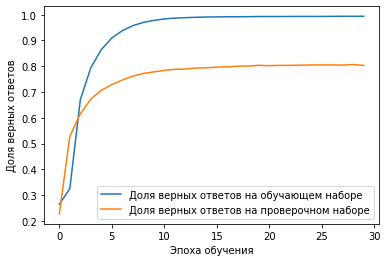

[[400, 'tanh', 0, 'relu', 0, 'relu'], 'train_acc = ', 0.8049]

Train on 32471 samples, validate on 8118 samples
Epoch 1/30
32471/32471 [==============================] - 14s 437us/sample - loss: 2.6027 - acc: 0.1907 - val_loss: 2.4260 - val_acc: 0.2025
Epoch 2/30
32471/32471 [==============================] - 13s 412us/sample - loss: 2.3346 - acc: 0.2616 - val_loss: 2.2738 - val_acc: 0.3098
Epoch 3/30
32471/32471 [==============================] - 13s 414us/sample - loss: 2.0971 - acc: 0.3927 - val_loss: 2.0387 - val_acc: 0.4192
Epoch 4/30
32471/32471 [==============================] - 13s 415us/sample - loss: 1.8416 - acc: 0.4832 - val_loss: 1.8584 - val_acc: 0.4574
Epoch 5/30
32471/32471 [==============================] - 13s 415us/sample - loss: 1.6427 - acc: 0.5405 - val_loss: 1.7220 - val_acc: 0.4986
Epoch 6/30
32471/32471 [==============================] - 13s 411us/sample - loss: 1.4814 - acc: 0.5936 - val_loss: 1.6130 - val_acc: 0.5303
Epoch 7/30
32471/32471 [==================

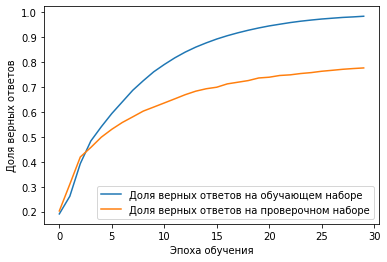

Train on 32471 samples, validate on 8118 samples
Epoch 1/30
32471/32471 [==============================] - 14s 442us/sample - loss: 2.5903 - acc: 0.1773 - val_loss: 2.4243 - val_acc: 0.2110
Epoch 2/30
32471/32471 [==============================] - 13s 401us/sample - loss: 2.3357 - acc: 0.2717 - val_loss: 2.2746 - val_acc: 0.3167
Epoch 3/30
32471/32471 [==============================] - 13s 397us/sample - loss: 2.0969 - acc: 0.3982 - val_loss: 2.0373 - val_acc: 0.4084
Epoch 4/30
32471/32471 [==============================] - 13s 407us/sample - loss: 1.8419 - acc: 0.4706 - val_loss: 1.8584 - val_acc: 0.4478
Epoch 5/30
32471/32471 [==============================] - 13s 413us/sample - loss: 1.6445 - acc: 0.5276 - val_loss: 1.7239 - val_acc: 0.4846
Epoch 6/30
32471/32471 [==============================] - 13s 412us/sample - loss: 1.4844 - acc: 0.5803 - val_loss: 1.6148 - val_acc: 0.5200
Epoch 7/30
32471/32471 [==============================] - 13s 413us/sample - loss: 1.3469 - acc: 0.6311 -

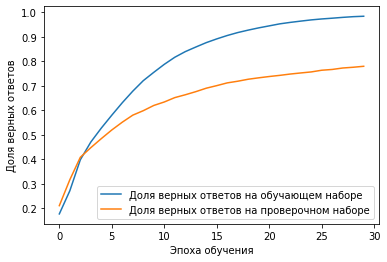

Train on 32471 samples, validate on 8118 samples
Epoch 1/30
32471/32471 [==============================] - 14s 441us/sample - loss: 2.6386 - acc: 0.1442 - val_loss: 2.4294 - val_acc: 0.1997
Epoch 2/30
32471/32471 [==============================] - 14s 417us/sample - loss: 2.3384 - acc: 0.2165 - val_loss: 2.2793 - val_acc: 0.3046
Epoch 3/30
32471/32471 [==============================] - 14s 416us/sample - loss: 2.1027 - acc: 0.3797 - val_loss: 2.0406 - val_acc: 0.4176
Epoch 4/30
32471/32471 [==============================] - 13s 414us/sample - loss: 1.8424 - acc: 0.4762 - val_loss: 1.8558 - val_acc: 0.4591
Epoch 5/30
32471/32471 [==============================] - 13s 412us/sample - loss: 1.6398 - acc: 0.5358 - val_loss: 1.7180 - val_acc: 0.4908
Epoch 6/30
32471/32471 [==============================] - 14s 416us/sample - loss: 1.4772 - acc: 0.5873 - val_loss: 1.6074 - val_acc: 0.5269
Epoch 7/30
32471/32471 [==============================] - 14s 416us/sample - loss: 1.3394 - acc: 0.6386 -

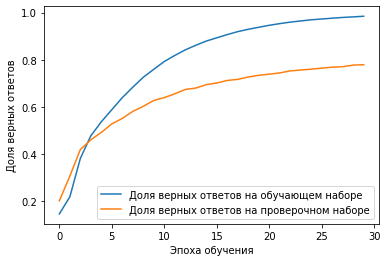

[[400, 'sigmoid', 0, 'relu', 0, 'relu'], 'train_acc = ', 0.7783]

Train on 32471 samples, validate on 8118 samples
Epoch 1/30
32471/32471 [==============================] - 14s 443us/sample - loss: 2.6275 - acc: 0.1932 - val_loss: 2.4515 - val_acc: 0.1997
Epoch 2/30
32471/32471 [==============================] - 14s 418us/sample - loss: 2.3822 - acc: 0.1934 - val_loss: 2.3485 - val_acc: 0.2062
Epoch 3/30
32471/32471 [==============================] - 14s 419us/sample - loss: 2.2189 - acc: 0.3108 - val_loss: 2.1547 - val_acc: 0.3643
Epoch 4/30
32471/32471 [==============================] - 14s 417us/sample - loss: 1.9769 - acc: 0.4388 - val_loss: 1.9643 - val_acc: 0.4308
Epoch 5/30
32471/32471 [==============================] - 13s 415us/sample - loss: 1.7718 - acc: 0.4977 - val_loss: 1.8231 - val_acc: 0.4696
Epoch 6/30
32471/32471 [==============================] - 14s 417us/sample - loss: 1.6081 - acc: 0.5484 - val_loss: 1.7081 - val_acc: 0.4940
Epoch 7/30
32471/32471 [===============

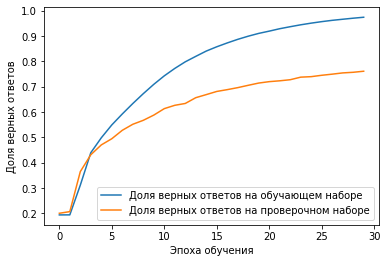

Train on 32471 samples, validate on 8118 samples
Epoch 1/30
32471/32471 [==============================] - 15s 448us/sample - loss: 2.6564 - acc: 0.1580 - val_loss: 2.4497 - val_acc: 0.2002
Epoch 2/30
32471/32471 [==============================] - 13s 414us/sample - loss: 2.3777 - acc: 0.2249 - val_loss: 2.3343 - val_acc: 0.3035
Epoch 3/30
32471/32471 [==============================] - 13s 415us/sample - loss: 2.2026 - acc: 0.3460 - val_loss: 2.1481 - val_acc: 0.3879
Epoch 4/30
32471/32471 [==============================] - 13s 415us/sample - loss: 1.9779 - acc: 0.4397 - val_loss: 1.9718 - val_acc: 0.4318
Epoch 5/30
32471/32471 [==============================] - 14s 417us/sample - loss: 1.7834 - acc: 0.4951 - val_loss: 1.8328 - val_acc: 0.4637
Epoch 6/30
32471/32471 [==============================] - 13s 413us/sample - loss: 1.6225 - acc: 0.5408 - val_loss: 1.7234 - val_acc: 0.5044
Epoch 7/30
32471/32471 [==============================] - 13s 416us/sample - loss: 1.4853 - acc: 0.5886 -

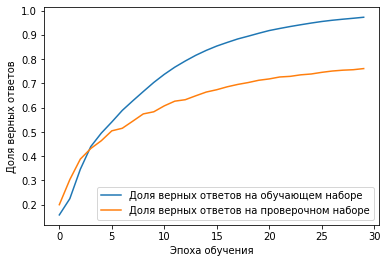

Train on 32471 samples, validate on 8118 samples
Epoch 1/30
32471/32471 [==============================] - 15s 448us/sample - loss: 2.5845 - acc: 0.2013 - val_loss: 2.4425 - val_acc: 0.2025
Epoch 2/30
32471/32471 [==============================] - 14s 419us/sample - loss: 2.3760 - acc: 0.2266 - val_loss: 2.3378 - val_acc: 0.2983
Epoch 3/30
32471/32471 [==============================] - 14s 417us/sample - loss: 2.2015 - acc: 0.3457 - val_loss: 2.1418 - val_acc: 0.3842
Epoch 4/30
32471/32471 [==============================] - 13s 416us/sample - loss: 1.9668 - acc: 0.4479 - val_loss: 1.9627 - val_acc: 0.4462
Epoch 5/30
32471/32471 [==============================] - 14s 416us/sample - loss: 1.7702 - acc: 0.5000 - val_loss: 1.8236 - val_acc: 0.4640
Epoch 6/30
32471/32471 [==============================] - 14s 419us/sample - loss: 1.6101 - acc: 0.5435 - val_loss: 1.7121 - val_acc: 0.4929
Epoch 7/30
32471/32471 [==============================] - 13s 416us/sample - loss: 1.4737 - acc: 0.5886 -

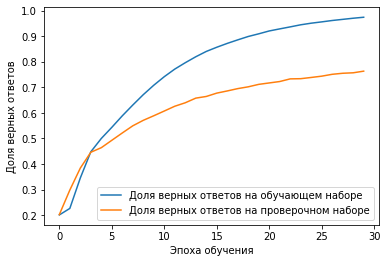

[[400, 'hard_sigmoid', 0, 'relu', 0, 'relu'], 'train_acc = ', 0.7615]

Train on 32471 samples, validate on 8118 samples
Epoch 1/30
32471/32471 [==============================] - 15s 448us/sample - loss: 2.4435 - acc: 0.2076 - val_loss: 2.0839 - val_acc: 0.3598
Epoch 2/30
32471/32471 [==============================] - 14s 417us/sample - loss: 1.6498 - acc: 0.5256 - val_loss: 1.5263 - val_acc: 0.5599
Epoch 3/30
32471/32471 [==============================] - 14s 417us/sample - loss: 1.1141 - acc: 0.7172 - val_loss: 1.2467 - val_acc: 0.6321
Epoch 4/30
32471/32471 [==============================] - 13s 414us/sample - loss: 0.7726 - acc: 0.8262 - val_loss: 1.0598 - val_acc: 0.6870
Epoch 5/30
32471/32471 [==============================] - 14s 419us/sample - loss: 0.5330 - acc: 0.8914 - val_loss: 0.9257 - val_acc: 0.7223
Epoch 6/30
32471/32471 [==============================] - 13s 415us/sample - loss: 0.3672 - acc: 0.9328 - val_loss: 0.8311 - val_acc: 0.7451
Epoch 7/30
32471/32471 [==========

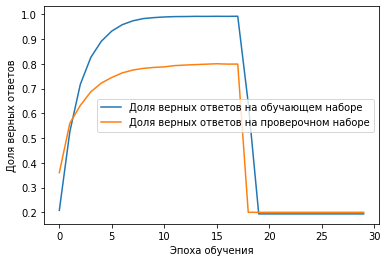

Train on 32471 samples, validate on 8118 samples
Epoch 1/30
32471/32471 [==============================] - 15s 448us/sample - loss: 2.3957 - acc: 0.2000 - val_loss: 2.0636 - val_acc: 0.3624
Epoch 2/30
32471/32471 [==============================] - 14s 418us/sample - loss: 1.6151 - acc: 0.5241 - val_loss: 1.4935 - val_acc: 0.5563
Epoch 3/30
32471/32471 [==============================] - 14s 418us/sample - loss: 1.0788 - acc: 0.7231 - val_loss: 1.2260 - val_acc: 0.6364
Epoch 4/30
32471/32471 [==============================] - 14s 416us/sample - loss: 0.7440 - acc: 0.8339 - val_loss: 1.0415 - val_acc: 0.6932
Epoch 5/30
32471/32471 [==============================] - 14s 416us/sample - loss: 0.5112 - acc: 0.8979 - val_loss: 0.9134 - val_acc: 0.7329
Epoch 6/30
32471/32471 [==============================] - 14s 417us/sample - loss: 0.3517 - acc: 0.9365 - val_loss: 0.8212 - val_acc: 0.7482
Epoch 7/30
32471/32471 [==============================] - 14s 416us/sample - loss: 0.2440 - acc: 0.9622 -

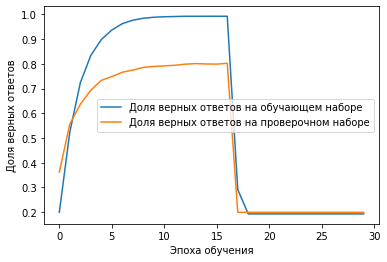

Train on 32471 samples, validate on 8118 samples
Epoch 1/30
32471/32471 [==============================] - 15s 449us/sample - loss: 2.4161 - acc: 0.2035 - val_loss: 2.1177 - val_acc: 0.2956
Epoch 2/30
32471/32471 [==============================] - 13s 415us/sample - loss: 1.6516 - acc: 0.5286 - val_loss: 1.5095 - val_acc: 0.5594
Epoch 3/30
32471/32471 [==============================] - 14s 417us/sample - loss: 1.0959 - acc: 0.7218 - val_loss: 1.2317 - val_acc: 0.6494
Epoch 4/30
32471/32471 [==============================] - 13s 414us/sample - loss: 0.7560 - acc: 0.8311 - val_loss: 1.0468 - val_acc: 0.6893
Epoch 5/30
32471/32471 [==============================] - 14s 416us/sample - loss: 0.5197 - acc: 0.8965 - val_loss: 0.9187 - val_acc: 0.7241
Epoch 6/30
32471/32471 [==============================] - 14s 419us/sample - loss: 0.3574 - acc: 0.9364 - val_loss: 0.8278 - val_acc: 0.7428
Epoch 7/30
32471/32471 [==============================] - 14s 419us/sample - loss: 0.2476 - acc: 0.9609 -

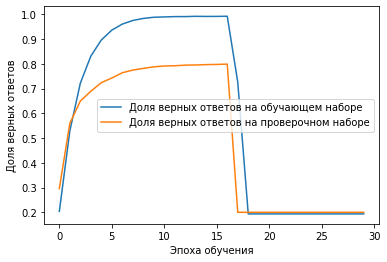

[[400, 'exponential', 0, 'relu', 0, 'relu'], 'train_acc = ', 0.1997]

Train on 32471 samples, validate on 8118 samples
Epoch 1/30
32471/32471 [==============================] - 15s 448us/sample - loss: 2.5252 - acc: 0.2729 - val_loss: 2.1585 - val_acc: 0.2483
Epoch 2/30
32471/32471 [==============================] - 14s 417us/sample - loss: 1.7934 - acc: 0.3690 - val_loss: 1.5713 - val_acc: 0.5399
Epoch 3/30
32471/32471 [==============================] - 14s 420us/sample - loss: 1.1595 - acc: 0.6943 - val_loss: 1.2522 - val_acc: 0.6381
Epoch 4/30
32471/32471 [==============================] - 14s 418us/sample - loss: 0.8011 - acc: 0.8203 - val_loss: 1.0716 - val_acc: 0.6847
Epoch 5/30
32471/32471 [==============================] - 14s 420us/sample - loss: 0.5745 - acc: 0.8858 - val_loss: 0.9520 - val_acc: 0.7159
Epoch 6/30
32471/32471 [==============================] - 14s 418us/sample - loss: 0.4219 - acc: 0.9255 - val_loss: 0.8647 - val_acc: 0.7373
Epoch 7/30
32471/32471 [===========

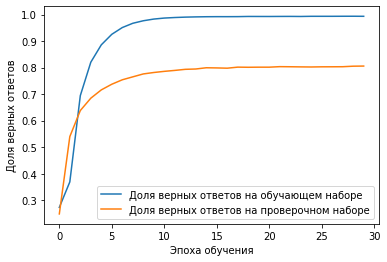

Train on 32471 samples, validate on 8118 samples
Epoch 1/30
32471/32471 [==============================] - 15s 455us/sample - loss: 2.5359 - acc: 0.2495 - val_loss: 2.1648 - val_acc: 0.2863
Epoch 2/30
32471/32471 [==============================] - 14s 418us/sample - loss: 1.8083 - acc: 0.3616 - val_loss: 1.5776 - val_acc: 0.5246
Epoch 3/30
32471/32471 [==============================] - 14s 419us/sample - loss: 1.1647 - acc: 0.6928 - val_loss: 1.2529 - val_acc: 0.6303
Epoch 4/30
32471/32471 [==============================] - 14s 420us/sample - loss: 0.8024 - acc: 0.8182 - val_loss: 1.0726 - val_acc: 0.6876
Epoch 5/30
32471/32471 [==============================] - 14s 420us/sample - loss: 0.5745 - acc: 0.8850 - val_loss: 0.9518 - val_acc: 0.7170
Epoch 6/30
32471/32471 [==============================] - 14s 420us/sample - loss: 0.4217 - acc: 0.9260 - val_loss: 0.8654 - val_acc: 0.7396
Epoch 7/30
32471/32471 [==============================] - 14s 416us/sample - loss: 0.3159 - acc: 0.9509 -

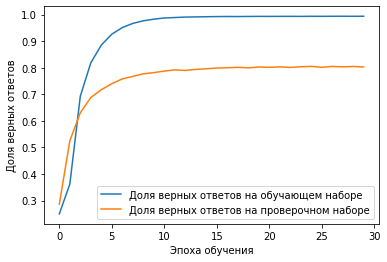

Train on 32471 samples, validate on 8118 samples
Epoch 1/30
32471/32471 [==============================] - 15s 456us/sample - loss: 2.5299 - acc: 0.2601 - val_loss: 2.1625 - val_acc: 0.2924
Epoch 2/30
32471/32471 [==============================] - 14s 420us/sample - loss: 1.8182 - acc: 0.3636 - val_loss: 1.5832 - val_acc: 0.5393
Epoch 3/30
32471/32471 [==============================] - 14s 417us/sample - loss: 1.1685 - acc: 0.6888 - val_loss: 1.2501 - val_acc: 0.6388
Epoch 4/30
32471/32471 [==============================] - 14s 418us/sample - loss: 0.8011 - acc: 0.8192 - val_loss: 1.0702 - val_acc: 0.6911
Epoch 5/30
32471/32471 [==============================] - 14s 419us/sample - loss: 0.5730 - acc: 0.8853 - val_loss: 0.9479 - val_acc: 0.7212
Epoch 6/30
32471/32471 [==============================] - 14s 421us/sample - loss: 0.4203 - acc: 0.9251 - val_loss: 0.8632 - val_acc: 0.7390
Epoch 7/30
32471/32471 [==============================] - 13s 413us/sample - loss: 0.3151 - acc: 0.9505 -

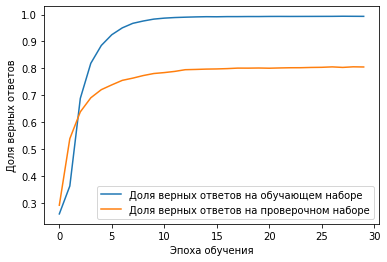

[[400, 'linear', 0, 'relu', 0, 'relu'], 'train_acc = ', 0.8046]

Результаты тестирования архитектуры сети
[[400, 'relu', 0, 'relu', 0, 'relu'], 'train_acc = ', 0.8048]
[[400, 'elu', 0, 'relu', 0, 'relu'], 'train_acc = ', 0.8039]
[[400, 'selu', 0, 'relu', 0, 'relu'], 'train_acc = ', 0.8052]
[[400, 'softplus', 0, 'relu', 0, 'relu'], 'train_acc = ', 0.8003]
[[400, 'softsign', 0, 'relu', 0, 'relu'], 'train_acc = ', 0.808]
[[400, 'tanh', 0, 'relu', 0, 'relu'], 'train_acc = ', 0.8049]
[[400, 'sigmoid', 0, 'relu', 0, 'relu'], 'train_acc = ', 0.7783]
[[400, 'hard_sigmoid', 0, 'relu', 0, 'relu'], 'train_acc = ', 0.7615]
[[400, 'exponential', 0, 'relu', 0, 'relu'], 'train_acc = ', 0.1997]
[[400, 'linear', 0, 'relu', 0, 'relu'], 'train_acc = ', 0.8046]


In [0]:
list_test_net = []
#Обучаем каждую сеть и выводим среднюю точность на проверочной выборке по 3 запускам
for currNet in net:
  acc = testModel(net = currNet, batch_size = 128, epochs = 30, iterations = 3)
  list_test_net.append([currNet, 'train_acc = ', round(sum(acc)/len(acc),4)])
  print(list_test_net[-1])
  print('='*100)
  print()

print('Результаты тестирования архитектуры сети')
for i in list_test_net:
  print(i)

## Вывод судя по точности на валидацтонной выборке наилучший результат показывают функции 

 - [[400, 'relu', 0, 'relu', 0, 'relu'], 'train_acc = ', 0.8048]
 - [[400, 'tanh', 0, 'relu', 0, 'relu'], 'train_acc = ', 0.8049]
 

## Судя по графикам обучения наиболее плавное обучение дают функции sigmoid, hard_sigmoid и плато они еще не достигли.
 - [[400, 'sigmoid', 0, 'relu', 0, 'relu'], 'train_acc = ', 0.7783]
 - [[400, 'hard_sigmoid', 0, 'relu', 0, 'relu'], 'train_acc = ', 0.7615]

## Дадим этим четырем функция больше эпох обучения

In [0]:
# Список для записи результатов тестирования
list_test_net = []
# Создаём сети с различной архитектурой
net = []
net.append([400, 'relu', 0, 'relu', 0, 'relu'])
net.append([400, 'tanh', 0, 'relu', 0, 'relu'])
net.append([400, 'sigmoid', 0, 'relu', 0, 'relu'])
net.append([400, 'hard_sigmoid', 0, 'relu', 0, 'relu'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 32471 samples, validate on 8118 samples
Epoch 1/50
32471/32471 [==============================] - 12s 374us/sample - loss: 2.6526 - acc: 0.2753 - val_loss: 2.2712 - val_acc: 0.2143
Epoch 2/50
32471/32471 [==============================] - 10s 320us/sample - loss: 1.8618 - acc: 0.3552 - val_loss: 1.5720 - val_acc: 0.5314
Epoch 3/50
32471/32471 [==============================] - 10s 321us/sample - loss: 1.1735 - acc: 0.6886 - val_loss: 1.2509 - val_acc: 0.6433
Epoch 4/50
32471/32471 [==============================] - 10s 322us/sample - loss: 0.8121 - acc: 0.8162 - val_loss: 1.0773 - val_acc: 0.6901
Epoch 5/50
32471/32471 [==============================] - 10s 322us/sample - loss: 0.5883 - acc: 0.8814 - val_loss: 0.9618 - val_acc: 0.7230
Epoch 6/50
32471/32471 [==============================] - 10s 321us/sam

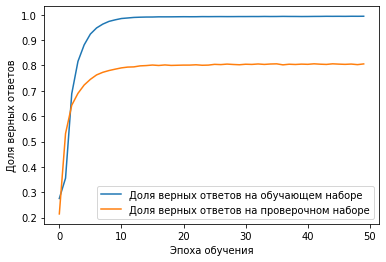

[[400, 'relu', 0, 'relu', 0, 'relu'], 'train_acc = ', 0.8062]

Train on 32471 samples, validate on 8118 samples
Epoch 1/50
32471/32471 [==============================] - 11s 353us/sample - loss: 2.5356 - acc: 0.2781 - val_loss: 2.1767 - val_acc: 0.2389
Epoch 2/50
32471/32471 [==============================] - 11s 348us/sample - loss: 1.8389 - acc: 0.3507 - val_loss: 1.6270 - val_acc: 0.5161
Epoch 3/50
32471/32471 [==============================] - 11s 347us/sample - loss: 1.2468 - acc: 0.6647 - val_loss: 1.3062 - val_acc: 0.6211
Epoch 4/50
32471/32471 [==============================] - 11s 345us/sample - loss: 0.8914 - acc: 0.7940 - val_loss: 1.1226 - val_acc: 0.6750
Epoch 5/50
32471/32471 [==============================] - 11s 350us/sample - loss: 0.6558 - acc: 0.8661 - val_loss: 0.9960 - val_acc: 0.7125
Epoch 6/50
32471/32471 [==============================] - 11s 345us/sample - loss: 0.4909 - acc: 0.9114 - val_loss: 0.9019 - val_acc: 0.7409
Epoch 7/50
32471/32471 [==================

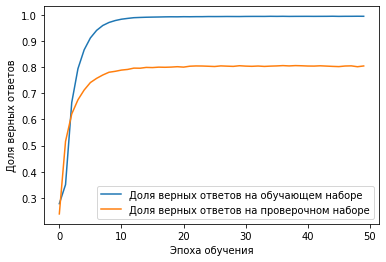

[[400, 'tanh', 0, 'relu', 0, 'relu'], 'train_acc = ', 0.8044]

Train on 32471 samples, validate on 8118 samples
Epoch 1/50
32471/32471 [==============================] - 11s 351us/sample - loss: 2.6112 - acc: 0.2333 - val_loss: 2.4354 - val_acc: 0.2494
Epoch 2/50
32471/32471 [==============================] - 11s 349us/sample - loss: 2.3444 - acc: 0.2376 - val_loss: 2.2979 - val_acc: 0.1994
Epoch 3/50
32471/32471 [==============================] - 11s 349us/sample - loss: 2.1206 - acc: 0.3611 - val_loss: 2.0568 - val_acc: 0.4029
Epoch 4/50
32471/32471 [==============================] - 11s 349us/sample - loss: 1.8583 - acc: 0.4712 - val_loss: 1.8683 - val_acc: 0.4528
Epoch 5/50
32471/32471 [==============================] - 11s 349us/sample - loss: 1.6570 - acc: 0.5322 - val_loss: 1.7274 - val_acc: 0.4927
Epoch 6/50
32471/32471 [==============================] - 11s 347us/sample - loss: 1.4941 - acc: 0.5837 - val_loss: 1.6165 - val_acc: 0.5281
Epoch 7/50
32471/32471 [==================

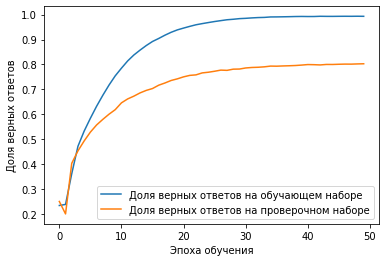

[[400, 'sigmoid', 0, 'relu', 0, 'relu'], 'train_acc = ', 0.8027]

Train on 32471 samples, validate on 8118 samples
Epoch 1/50
32471/32471 [==============================] - 12s 365us/sample - loss: 2.6678 - acc: 0.1670 - val_loss: 2.4525 - val_acc: 0.1959
Epoch 2/50
32471/32471 [==============================] - 12s 359us/sample - loss: 2.3770 - acc: 0.2463 - val_loss: 2.3447 - val_acc: 0.2778
Epoch 3/50
32471/32471 [==============================] - 12s 359us/sample - loss: 2.2109 - acc: 0.3466 - val_loss: 2.1598 - val_acc: 0.3689
Epoch 4/50
32471/32471 [==============================] - 12s 360us/sample - loss: 1.9855 - acc: 0.4388 - val_loss: 1.9805 - val_acc: 0.4281
Epoch 5/50
32471/32471 [==============================] - 12s 359us/sample - loss: 1.7885 - acc: 0.4909 - val_loss: 1.8338 - val_acc: 0.4543
Epoch 6/50
32471/32471 [==============================] - 12s 360us/sample - loss: 1.6259 - acc: 0.5398 - val_loss: 1.7180 - val_acc: 0.4837
Epoch 7/50
32471/32471 [===============

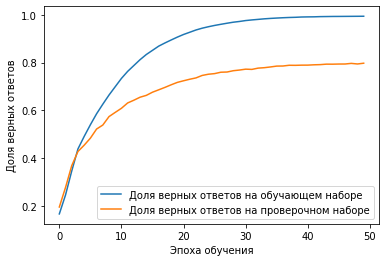

[[400, 'hard_sigmoid', 0, 'relu', 0, 'relu'], 'train_acc = ', 0.7971]

Результаты тестирования архитектуры сети
[[400, 'relu', 0, 'relu', 0, 'relu'], 'train_acc = ', 0.8062]
[[400, 'tanh', 0, 'relu', 0, 'relu'], 'train_acc = ', 0.8044]
[[400, 'sigmoid', 0, 'relu', 0, 'relu'], 'train_acc = ', 0.8027]
[[400, 'hard_sigmoid', 0, 'relu', 0, 'relu'], 'train_acc = ', 0.7971]


In [0]:
list_test_net = []
#Обучаем каждую сеть и выводим среднюю точность на проверочной выборке по 1 запуску
for currNet in net:
  acc = testModel(net = currNet, batch_size = 128, epochs = 50, iterations = 1)
  list_test_net.append([currNet, 'train_acc = ', round(sum(acc)/len(acc),4)])
  print(list_test_net[-1])
  print('='*100)
  print()

print('Результаты тестирования архитектуры сети')
for i in list_test_net:
  print(i)

### Тестируем двух слойные сети

In [0]:
# Список для записи результатов тестирования
list_test_net = []
# Создаём сети с различной архитектурой
net = []
net.append([200, 'relu', 200, 'relu', 0, 'relu'])
net.append([300, 'relu', 300, 'relu', 0, 'relu'])
net.append([400, 'relu', 400, 'relu', 0, 'relu'])
net.append([500, 'relu', 500, 'relu', 0, 'relu'])
net.append([600, 'relu', 600, 'relu', 0, 'relu'])

Train on 32471 samples, validate on 8118 samples
Epoch 1/50
32471/32471 [==============================] - 9s 282us/sample - loss: 2.6227 - acc: 0.2197 - val_loss: 2.2651 - val_acc: 0.1957
Epoch 2/50
32471/32471 [==============================] - 9s 267us/sample - loss: 1.8912 - acc: 0.3168 - val_loss: 1.5791 - val_acc: 0.5119
Epoch 3/50
32471/32471 [==============================] - 9s 267us/sample - loss: 1.1559 - acc: 0.6722 - val_loss: 1.2148 - val_acc: 0.6394
Epoch 4/50
32471/32471 [==============================] - 9s 268us/sample - loss: 0.7239 - acc: 0.8301 - val_loss: 1.0176 - val_acc: 0.7008
Epoch 5/50
32471/32471 [==============================] - 9s 272us/sample - loss: 0.4636 - acc: 0.9069 - val_loss: 0.8916 - val_acc: 0.7422
Epoch 6/50
32471/32471 [==============================] - 9s 271us/sample - loss: 0.3040 - acc: 0.9465 - val_loss: 0.8184 - val_acc: 0.7593
Epoch 7/50
32471/32471 [==============================] - 9s 275us/sample - loss: 0.2053 - acc: 0.9690 - val_lo

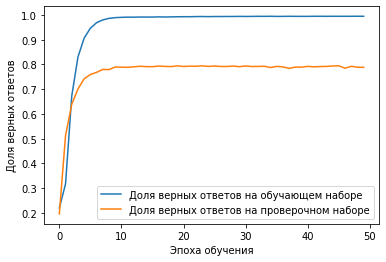

[[200, 'relu', 200, 'relu', 0, 'relu'], 'train_acc = ', 0.7884]

Train on 32471 samples, validate on 8118 samples
Epoch 1/50
32471/32471 [==============================] - 10s 321us/sample - loss: 2.5749 - acc: 0.2089 - val_loss: 2.1890 - val_acc: 0.2078
Epoch 2/50
32471/32471 [==============================] - 10s 306us/sample - loss: 1.7271 - acc: 0.3785 - val_loss: 1.3929 - val_acc: 0.5638
Epoch 3/50
32471/32471 [==============================] - 10s 306us/sample - loss: 0.9251 - acc: 0.7450 - val_loss: 1.0577 - val_acc: 0.6851
Epoch 4/50
32471/32471 [==============================] - 10s 305us/sample - loss: 0.5106 - acc: 0.8854 - val_loss: 0.8768 - val_acc: 0.7414
Epoch 5/50
32471/32471 [==============================] - 10s 306us/sample - loss: 0.2965 - acc: 0.9432 - val_loss: 0.7877 - val_acc: 0.7660
Epoch 6/50
32471/32471 [==============================] - 10s 305us/sample - loss: 0.1815 - acc: 0.9703 - val_loss: 0.7457 - val_acc: 0.7731
Epoch 7/50
32471/32471 [================

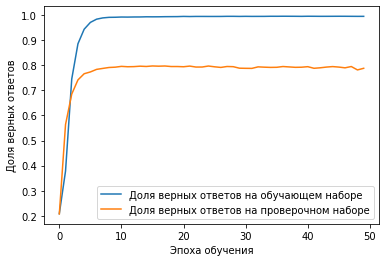

[[300, 'relu', 300, 'relu', 0, 'relu'], 'train_acc = ', 0.7876]

Train on 32471 samples, validate on 8118 samples
Epoch 1/50
32471/32471 [==============================] - 12s 371us/sample - loss: 2.4981 - acc: 0.2106 - val_loss: 2.0839 - val_acc: 0.1951
Epoch 2/50
32471/32471 [==============================] - 11s 354us/sample - loss: 1.5016 - acc: 0.4723 - val_loss: 1.2600 - val_acc: 0.6151
Epoch 3/50
32471/32471 [==============================] - 11s 352us/sample - loss: 0.7434 - acc: 0.8057 - val_loss: 0.9609 - val_acc: 0.7207
Epoch 4/50
32471/32471 [==============================] - 11s 352us/sample - loss: 0.3814 - acc: 0.9209 - val_loss: 0.8241 - val_acc: 0.7483
Epoch 5/50
32471/32471 [==============================] - 12s 354us/sample - loss: 0.2099 - acc: 0.9628 - val_loss: 0.7616 - val_acc: 0.7678
Epoch 6/50
32471/32471 [==============================] - 11s 350us/sample - loss: 0.1248 - acc: 0.9811 - val_loss: 0.7301 - val_acc: 0.7832
Epoch 7/50
32471/32471 [================

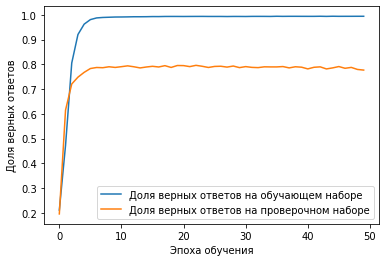

[[400, 'relu', 400, 'relu', 0, 'relu'], 'train_acc = ', 0.7769]

Train on 32471 samples, validate on 8118 samples
Epoch 1/50
32471/32471 [==============================] - 13s 416us/sample - loss: 2.4189 - acc: 0.2084 - val_loss: 1.9533 - val_acc: 0.2126
Epoch 2/50
32471/32471 [==============================] - 13s 396us/sample - loss: 1.3228 - acc: 0.5732 - val_loss: 1.1727 - val_acc: 0.6465
Epoch 3/50
32471/32471 [==============================] - 13s 398us/sample - loss: 0.6169 - acc: 0.8505 - val_loss: 0.9001 - val_acc: 0.7317
Epoch 4/50
32471/32471 [==============================] - 13s 395us/sample - loss: 0.3011 - acc: 0.9387 - val_loss: 0.7914 - val_acc: 0.7598
Epoch 5/50
32471/32471 [==============================] - 13s 395us/sample - loss: 0.1610 - acc: 0.9727 - val_loss: 0.7407 - val_acc: 0.7781
Epoch 6/50
32471/32471 [==============================] - 13s 399us/sample - loss: 0.0949 - acc: 0.9857 - val_loss: 0.7301 - val_acc: 0.7791
Epoch 7/50
32471/32471 [================

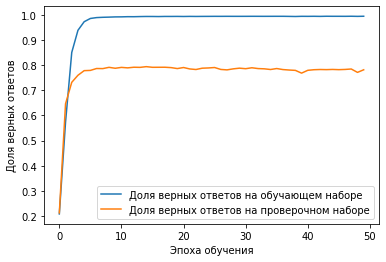

[[500, 'relu', 500, 'relu', 0, 'relu'], 'train_acc = ', 0.7816]

Train on 32471 samples, validate on 8118 samples
Epoch 1/50
32471/32471 [==============================] - 13s 394us/sample - loss: 2.4078 - acc: 0.2091 - val_loss: 1.9298 - val_acc: 0.1951
Epoch 2/50
32471/32471 [==============================] - 12s 373us/sample - loss: 1.2877 - acc: 0.5531 - val_loss: 1.1123 - val_acc: 0.6552
Epoch 3/50
32471/32471 [==============================] - 12s 372us/sample - loss: 0.5423 - acc: 0.8651 - val_loss: 0.8501 - val_acc: 0.7444
Epoch 4/50
32471/32471 [==============================] - 12s 376us/sample - loss: 0.2482 - acc: 0.9497 - val_loss: 0.7555 - val_acc: 0.7735
Epoch 5/50
32471/32471 [==============================] - 12s 374us/sample - loss: 0.1291 - acc: 0.9778 - val_loss: 0.7177 - val_acc: 0.7879
Epoch 6/50
32471/32471 [==============================] - 12s 372us/sample - loss: 0.0769 - acc: 0.9867 - val_loss: 0.7296 - val_acc: 0.7875
Epoch 7/50
32471/32471 [================

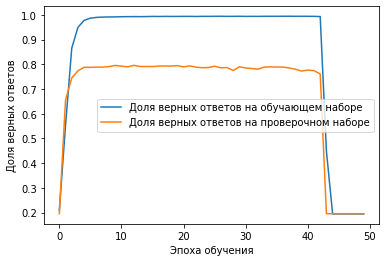

[[600, 'relu', 600, 'relu', 0, 'relu'], 'train_acc = ', 0.1951]

Результаты тестирования архитектуры сети
[[200, 'relu', 200, 'relu', 0, 'relu'], 'train_acc = ', 0.7884]
[[300, 'relu', 300, 'relu', 0, 'relu'], 'train_acc = ', 0.7876]
[[400, 'relu', 400, 'relu', 0, 'relu'], 'train_acc = ', 0.7769]
[[500, 'relu', 500, 'relu', 0, 'relu'], 'train_acc = ', 0.7816]
[[600, 'relu', 600, 'relu', 0, 'relu'], 'train_acc = ', 0.1951]


In [0]:
list_test_net = []
#Обучаем каждую сеть и выводим среднюю точность на проверочной выборке по 1 запуску
for currNet in net:
  acc = testModel(net = currNet, batch_size = 128, epochs = 50, iterations = 1)
  list_test_net.append([currNet, 'train_acc = ', round(sum(acc)/len(acc),4)])
  print(list_test_net[-1])
  print('='*100)
  print()

print('Результаты тестирования архитектуры сети')
for i in list_test_net:
  print(i)

## Проверим влияние нормализации данных

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 34304 samples, validate on 8577 samples
Epoch 1/35
34304/34304 [==============================] - 7s 217us/sample - loss: 2.8440 - acc: 0.2314 - val_loss: 2.5696 - val_acc: 0.2261
Epoch 2/35
34304/34304 [==============================] - 6s 169us/sample - loss: 2.3227 - acc: 0.2265 - val_loss: 2.1387 - val_acc: 0.1900
Epoch 3/35
34304/34304 [==============================] - 6s 170us/sample - loss: 1.8739 - acc: 0.3111 - val_loss: 1.6930 - val_acc: 0.5033
Epoch 4/35
34304/34304 [==============================] - 6s 169us/sample - loss: 1.3983 - acc: 0.6088 - val_loss: 1.4026 - val_acc: 0.5771
Epoch 5/35
34304/34304 [==============================] - 6s 170us/sample - loss: 1.1048 - acc: 0.7081 - val_loss: 1.2435 - val_acc: 0.6341
Epoch 6/35
34304/34304 [==============================] - 6s 169us/sample - 

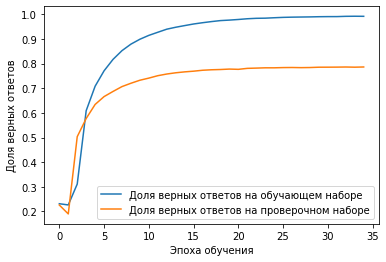

Результат обучения нейросети
val_acc =  0.7861



In [0]:
#Создаём полносвязную сеть
model01 = Sequential()
model01.add(Dense(400, input_dim=xTrain01.shape[1], activation="relu"))
model01.add(Dropout(0.25))
model01.add(Dense(yTrain.shape[1], activation='sigmoid'))

model01.compile(optimizer = Adam(lr=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

#Обучаем сеть на выборке, сформированной по bag of words - xTrain01
history = model01.fit(xTrain01, 
                      yTrain, 
                      epochs=35,
                      batch_size=256,
                      validation_data=(xVal01, yVal))

plt.plot(history.history['acc'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_acc'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

acc = history.history['val_acc'][-1]
print('='*100)
print('Результат обучения нейросети')
print('val_acc = ', np.round(acc,4))
print('='*100)
print()

## Проверим нормализацию через ButchNormalization

Train on 34304 samples, validate on 8577 samples
Epoch 1/35
34304/34304 [==============================] - 7s 194us/sample - loss: 2.4038 - acc: 0.3074 - val_loss: 2.3173 - val_acc: 0.1891
Epoch 2/35
34304/34304 [==============================] - 6s 180us/sample - loss: 0.8944 - acc: 0.7034 - val_loss: 1.6337 - val_acc: 0.3716
Epoch 3/35
34304/34304 [==============================] - 6s 180us/sample - loss: 0.2756 - acc: 0.9336 - val_loss: 1.0126 - val_acc: 0.6714
Epoch 4/35
34304/34304 [==============================] - 6s 180us/sample - loss: 0.1279 - acc: 0.9768 - val_loss: 0.7126 - val_acc: 0.7777
Epoch 5/35
34304/34304 [==============================] - 6s 180us/sample - loss: 0.0798 - acc: 0.9871 - val_loss: 0.6826 - val_acc: 0.7958
Epoch 6/35
34304/34304 [==============================] - 6s 181us/sample - loss: 0.0569 - acc: 0.9898 - val_loss: 0.7071 - val_acc: 0.7997
Epoch 7/35
34304/34304 [==============================] - 6s 179us/sample - loss: 0.0447 - acc: 0.9911 - val_lo

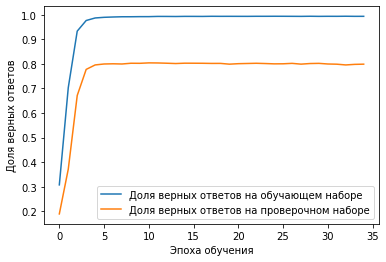

Результат обучения нейросети
val_acc =  0.799



In [0]:
#Создаём полносвязную сеть
model01 = Sequential()
model01.add(BatchNormalization())
model01.add(Dense(400, input_dim=xTrain01.shape[1], activation="relu"))
model01.add(Dense(yTrain.shape[1], activation='sigmoid'))

model01.compile(optimizer = Adam(lr=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

#Обучаем сеть на выборке, сформированной по bag of words - xTrain01
history = model01.fit(xTrain01, 
                      yTrain, 
                      epochs=35,
                      batch_size=256,
                      validation_data=(xVal01, yVal))

plt.plot(history.history['acc'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_acc'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

acc = history.history['val_acc'][-1]
print('='*100)
print('Результат обучения нейросети')
print('val_acc = ', np.round(acc,4))
print('='*100)
print()

### Вывод Применение различных видов нормализации данных к улучшению точности обучения не привело

# Финальная версия сети

Train on 34304 samples, validate on 8577 samples
Epoch 1/35
34304/34304 [==============================] - 7s 209us/sample - loss: 2.7534 - acc: 0.2105 - val_loss: 2.4026 - val_acc: 0.2100
Epoch 2/35
34304/34304 [==============================] - 7s 195us/sample - loss: 2.1295 - acc: 0.2578 - val_loss: 1.9065 - val_acc: 0.4308
Epoch 3/35
34304/34304 [==============================] - 7s 196us/sample - loss: 1.4725 - acc: 0.6090 - val_loss: 1.3923 - val_acc: 0.5845
Epoch 4/35
34304/34304 [==============================] - 7s 195us/sample - loss: 1.0160 - acc: 0.7531 - val_loss: 1.1820 - val_acc: 0.6619
Epoch 5/35
34304/34304 [==============================] - 7s 195us/sample - loss: 0.7572 - acc: 0.8349 - val_loss: 1.0488 - val_acc: 0.6988
Epoch 6/35
34304/34304 [==============================] - 7s 194us/sample - loss: 0.5837 - acc: 0.8841 - val_loss: 0.9555 - val_acc: 0.7211
Epoch 7/35
34304/34304 [==============================] - 7s 194us/sample - loss: 0.4591 - acc: 0.9170 - val_lo

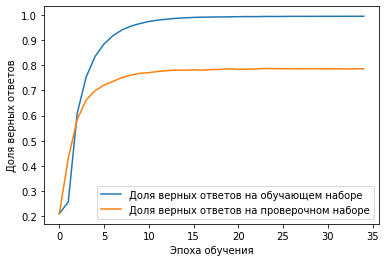

Результат обучения нейросети
val_acc =  0.7852



In [0]:
#Создаём полносвязную сеть
model01 = Sequential()
model01.add(Dense(600, input_dim=xTrain01.shape[1], activation="relu"))
model01.add(Dense(yTrain.shape[1], activation='sigmoid'))

model01.compile(optimizer = Adam(lr=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

#Обучаем сеть на выборке, сформированной по bag of words - xTrain01
history = model01.fit(xTrain01, 
                      yTrain, 
                      epochs=35,
                      batch_size=256,
                      validation_data=(xVal01, yVal))

plt.plot(history.history['acc'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_acc'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

acc = history.history['val_acc'][-1]
print('='*100)
print('Результат обучения нейросети')
print('val_acc = ', np.round(acc,4))
print('='*100)
print()

Train on 34304 samples, validate on 8577 samples
Epoch 1/5
34304/34304 [==============================] - 7s 212us/sample - loss: 0.0188 - acc: 0.9952 - val_loss: 0.7971 - val_acc: 0.7847
Epoch 2/5
34304/34304 [==============================] - 7s 194us/sample - loss: 0.0183 - acc: 0.9952 - val_loss: 0.7939 - val_acc: 0.7857
Epoch 3/5
34304/34304 [==============================] - 7s 194us/sample - loss: 0.0180 - acc: 0.9953 - val_loss: 0.7930 - val_acc: 0.7848
Epoch 4/5
34304/34304 [==============================] - 7s 194us/sample - loss: 0.0177 - acc: 0.9953 - val_loss: 0.7995 - val_acc: 0.7856
Epoch 5/5
34304/34304 [==============================] - 7s 195us/sample - loss: 0.0174 - acc: 0.9953 - val_loss: 0.8009 - val_acc: 0.7849


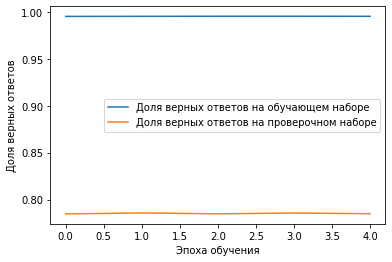

Результат обучения нейросети
val_acc =  0.7849



In [0]:
# Дообучение сети
model01.compile(optimizer = Adam(lr=0.00001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

#Обучаем сеть на выборке, сформированной по bag of words - xTrain01
history = model01.fit(xTrain01, 
                      yTrain, 
                      epochs=5,
                      batch_size=256,
                      validation_data=(xVal01, yVal))

plt.plot(history.history['acc'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_acc'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

acc = history.history['val_acc'][-1]
print('='*100)
print('Результат обучения нейросети')
print('val_acc = ', np.round(acc,4))
print('='*100)
print()

In [0]:
# Функция распознавания нужного обращения 
# разделением его на фрагменты и распознаванием фрагментов 

def recognize_message(model, text):

  #сообщение переводим в индексы
  text_in_WordInd_1 = tokenizer.texts_to_sequences([text]) 

  # делим сообщение на куски
  split_text = split_message(text_in_WordInd_1[0], xLen, step)

  # преобразуем назад векторы индексов в текстовые сообщения
  split_texts_1 = []

  items = list(tokenizer.word_index.items())

  for num in range(len(split_text)):
    cur_text = split_text[num]
    cur_mes = []
    for i in cur_text:
      char = items[i-1][0]
      cur_mes.append(char)
    split_texts_1.append(cur_mes)

  #преобразуем в bag of words
  xTex = tokenizer.texts_to_matrix(split_texts_1) 

  # предсказываем сообщение по всем частям
  currPred = model01.predict(xTex)

  # определяем класс для каждой части сообщения
  list_pred =[]
  for i in currPred:
    recognizedClass = np.argmax(i)
    list_pred.append(recognizedClass)

  # Определяем уникальные классы в результатах распознавания
  list_pred_set = set(list_pred) 

  # считем количество частей по классам
  dict_count_class = {}
  for i in list_pred_set:
    count = 0
    for j in list_pred:
      if i == j:
        count += 1
    dict_count_class[i]=count

  # Какого класса больше тот и победил
  win_class = 0
  for i in dict_count_class:
    if dict_count_class[i] > win_class:
      win_class = i
  #По номеру класса выводим описание класса

  return win_class, encoder.inverse_transform([win_class])[0] # classes[win_class]
  

In [0]:
# Функция вывода класса сообщения в формате: номер и текст 
def get_true_class(num):
  true_classesEncoded = encoder.transform([df.values[num_message][1]])
  tru_class_txt = df.values[num_message][1]
  return true_classesEncoded[0], tru_class_txt


In [0]:
# Опрелелим класс сообщения
num_message = 5678

print (df.values[num_message][0])
print()

# Из дата сета берем истинный класс сообщения
true_cl = get_true_class(num)
print('Класс Сообщения по обучащей выборке - ', true_cl[0], ' - ', true_cl[1])

# Предсказываем класс сообщения 
message_class = recognize_message(model01, texts[num_message])
print('Предсказанный класс сообщения       - ', message_class[0], ' - ', message_class[1])


Добрый день! Обращаюсь к Вам с проблемой заброшенной территорией самом центре города котороя превратилась в откровенную помойку и постоянным местом жительства бездомных собак! На это огромное место так и просится хорошая спортивная площадка! К своему обращению прикладываю фото и видео материал, но лучше увидеть все это вживую т. к. весь масштаб проблемы не передать! С уважением! 29.03.2019

Класс Сообщения по обучащей выборке -  2  -  Благо­­устрой­­ство
Предсказанный класс сообщения       -  2  -  Благо­­устрой­­ство


### Вывод: В случае разбиения сообщения на части с определенным шагом наблюдается явное улучшение точности распознавания к какому классу относится сообщение.
- В базовом ноутбуке точность распознавания класса сообщения составляла около 50%
- С помощью разбиения сообщения на части точность распознавания увеличилась до 80%


### P/S Мысли по поводу датасета:

- датасет имеет большой дисбаланс по классам, возможная причина том, что в категориях сообщений присутствуют непечатные символы и некоторые категории  затроились и зачетверились.
Если категори сообщений поправить, то получится всего 10 классов: 
 
 1. Дороги и транспорт
 2. ЖКХ
 3. Строительство
 4. Спорт
 5. Благо­­устрой­­ство
 7. Образование и наука
 8. Культура
 9. Демография
 10. Социальная сфера

а не 22 как сейчас:

0 Дороги и транспорт
1 ЖКХ
2 Строительство
3 Спорт
4 Дороги и транспорт
5 Дороги и транспорт
6 Дороги и транспорт
7 Дороги и транспорт
8 Благо­­устрой­­ство
9 Дороги и транспорт
10 Спорт
11 Дороги и транспорт
12 Спорт
13 Образование и наука
14 Строительство
15 ЖКХ
16 Благо­­устрой­­ство
17 Культура
18 ЖКХ
19 Дороги и транспорт
20 Демография
21 Социальная сфера

In [0]:
###########################
# Распознаём тестовую выборку и выводим результаты
##########################
def recognizeMultiClass(model, xTest, yTest, modelName):
  print("НЕЙРОНКА: ", modelName)
  print()
  
  currPred = model.predict(xTest)
  class_name = np.unique(classes)
  #nClasses = 22
  y_pred = np.zeros(nClasses)
  y_test = np.zeros(nClasses)

  for i in range(len(yTest)):
    y_test[np.argmax(yTest[i])] += 1
    if np.argmax(currPred[i]) == np.argmax(yTest[i]):
      y_pred[np.argmax(currPred[i])] += 1 

  y_summary = y_pred / y_test
  #Проходим по всем классам
  for i in range(nClasses): 
    print(class_name[i], 'Распознано:', round(y_summary[i] * 100,1), '%')
  return 

In [0]:
recognizeMultiClass(model01, xVal01, yVal, 'Финальная Сеть')

НЕЙРОНКА:  Финальная Сеть

nan Распознано: 71.4 %
Бизнес Распознано: 72.3 %
Благо­­устрой­­ство Распознано: 80.9 %
Борьба с коррупцией Распознано: 76.8 %
Демография Распознано: 39.1 %
Дороги и транспорт Распознано: 81.4 %
Другое Распознано: 70.9 %
ЖКХ Распознано: 83.4 %
Здравоохранение Распознано: 86.0 %
Земельные отношения Распознано: 77.5 %
Культура Распознано: 81.8 %
Образование и наука Распознано: 83.4 %
Органы власти Распознано: 75.6 %
Правопорядок Распознано: 75.5 %
Промышленность Распознано: 46.2 %
Сельское хозяйство Распознано: 82.8 %
Социальная сфера Распознано: 78.2 %
Спорт Распознано: 82.1 %
Строительство Распознано: 80.8 %
Труд и занятость населения Распознано: 77.0 %
Туризм Распознано: 69.2 %
Экология Распознано: 61.2 %
